# Texts

## V1

In [3]:
text_linear_v1="""Linear model, 1 samples got a PSNR of 10.35
Linear model, 2 samples got a PSNR of 10.32
Linear model, 3 samples got a PSNR of 10.01
Linear model, 4 samples got a PSNR of 10.34
Linear model, 5 samples got a PSNR of 11.47
Linear model, 6 samples got a PSNR of 10.66
Linear model, 7 samples got a PSNR of 10.93
Linear model, 8 samples got a PSNR of 10.91
Linear model, 9 samples got a PSNR of 11.19
Linear model, 10 samples got a PSNR of 10.78
Linear model, 11 samples got a PSNR of 11.53
Linear model, 12 samples got a PSNR of 11.80
Linear model, 13 samples got a PSNR of 11.67
Linear model, 14 samples got a PSNR of 11.39
Linear model, 16 samples got a PSNR of 12.65
Linear model, 17 samples got a PSNR of 12.02
Linear model, 19 samples got a PSNR of 11.81
Linear model, 21 samples got a PSNR of 12.19
Linear model, 23 samples got a PSNR of 12.29
Linear model, 25 samples got a PSNR of 12.63
Linear model, 28 samples got a PSNR of 12.12
Linear model, 31 samples got a PSNR of 11.89
Linear model, 34 samples got a PSNR of 12.55
Linear model, 37 samples got a PSNR of 13.28
Linear model, 41 samples got a PSNR of 13.16
Linear model, 45 samples got a PSNR of 13.18
Linear model, 49 samples got a PSNR of 12.83
Linear model, 54 samples got a PSNR of 12.85
Linear model, 59 samples got a PSNR of 13.43
Linear model, 65 samples got a PSNR of 13.70
Linear model, 72 samples got a PSNR of 13.83
Linear model, 79 samples got a PSNR of 14.36
Linear model, 86 samples got a PSNR of 14.08
Linear model, 95 samples got a PSNR of 14.41
Linear model, 104 samples got a PSNR of 14.34
Linear model, 114 samples got a PSNR of 14.56
Linear model, 126 samples got a PSNR of 14.65
Linear model, 138 samples got a PSNR of 14.78
Linear model, 151 samples got a PSNR of 14.87
Linear model, 166 samples got a PSNR of 14.85
Linear model, 183 samples got a PSNR of 15.11
Linear model, 200 samples got a PSNR of 15.19
Linear model, 220 samples got a PSNR of 15.40
Linear model, 242 samples got a PSNR of 15.59
Linear model, 265 samples got a PSNR of 15.64
Linear model, 291 samples got a PSNR of 15.84
Linear model, 319 samples got a PSNR of 15.79
Linear model, 351 samples got a PSNR of 15.89
Linear model, 385 samples got a PSNR of 16.10
Linear model, 422 samples got a PSNR of 16.29
Linear model, 464 samples got a PSNR of 16.37
Linear model, 509 samples got a PSNR of 16.41
Linear model, 559 samples got a PSNR of 16.55
Linear model, 613 samples got a PSNR of 16.88
Linear model, 673 samples got a PSNR of 16.86
Linear model, 739 samples got a PSNR of 16.98
Linear model, 811 samples got a PSNR of 17.18
Linear model, 890 samples got a PSNR of 17.30
Linear model, 977 samples got a PSNR of 17.51
Linear model, 1072 samples got a PSNR of 17.58
Linear model, 1176 samples got a PSNR of 17.70
Linear model, 1291 samples got a PSNR of 17.68
Linear model, 1417 samples got a PSNR of 18.02
Linear model, 1555 samples got a PSNR of 18.18
Linear model, 1707 samples got a PSNR of 18.38
Linear model, 1873 samples got a PSNR of 18.59
Linear model, 2056 samples got a PSNR of 18.75
Linear model, 2257 samples got a PSNR of 19.06
Linear model, 2477 samples got a PSNR of 19.24
Linear model, 2718 samples got a PSNR of 19.31
Linear model, 2983 samples got a PSNR of 19.72
Linear model, 3274 samples got a PSNR of 20.07
Linear model, 3593 samples got a PSNR of 20.26
Linear model, 3944 samples got a PSNR of 20.46
Linear model, 4328 samples got a PSNR of 20.73
Linear model, 4750 samples got a PSNR of 21.00
Linear model, 5214 samples got a PSNR of 21.30
Linear model, 5722 samples got a PSNR of 21.59
Linear model, 6280 samples got a PSNR of 21.74
Linear model, 6892 samples got a PSNR of 22.14
Linear model, 7564 samples got a PSNR of 22.38
Linear model, 8302 samples got a PSNR of 22.65
Linear model, 9111 samples got a PSNR of 22.80
Linear model, 10000 samples got a PSNR of 23.09
"""

text_neural_v1="""Neural model, 1 samples got a PSNR of 11.26
Neural model, 2 samples got a PSNR of 11.11
Neural model, 3 samples got a PSNR of 11.16
Neural model, 4 samples got a PSNR of 11.39
Neural model, 5 samples got a PSNR of 11.11
Neural model, 6 samples got a PSNR of 11.42
Neural model, 7 samples got a PSNR of 11.49
Neural model, 8 samples got a PSNR of 11.47
Neural model, 9 samples got a PSNR of 11.56
Neural model, 10 samples got a PSNR of 11.61
Neural model, 11 samples got a PSNR of 11.83
Neural model, 12 samples got a PSNR of 11.51
Neural model, 13 samples got a PSNR of 11.87
Neural model, 14 samples got a PSNR of 11.86
Neural model, 16 samples got a PSNR of 11.71
Neural model, 17 samples got a PSNR of 11.90
Neural model, 19 samples got a PSNR of 11.93
Neural model, 21 samples got a PSNR of 11.95
Neural model, 23 samples got a PSNR of 12.22
Neural model, 25 samples got a PSNR of 12.09
Neural model, 28 samples got a PSNR of 12.50
Neural model, 31 samples got a PSNR of 12.35
Neural model, 34 samples got a PSNR of 12.55
Neural model, 37 samples got a PSNR of 12.41
Neural model, 41 samples got a PSNR of 12.48
Neural model, 45 samples got a PSNR of 12.98
Neural model, 49 samples got a PSNR of 13.40
Neural model, 54 samples got a PSNR of 13.65
Neural model, 59 samples got a PSNR of 13.49
Neural model, 65 samples got a PSNR of 12.57
Neural model, 72 samples got a PSNR of 13.09
Neural model, 79 samples got a PSNR of 13.23
Neural model, 86 samples got a PSNR of 13.36
Neural model, 95 samples got a PSNR of 13.32
Neural model, 104 samples got a PSNR of 13.47
Neural model, 114 samples got a PSNR of 13.70
Neural model, 126 samples got a PSNR of 13.84
Neural model, 138 samples got a PSNR of 13.81
Neural model, 151 samples got a PSNR of 13.96
Neural model, 166 samples got a PSNR of 14.08
Neural model, 183 samples got a PSNR of 14.25
Neural model, 200 samples got a PSNR of 14.28
Neural model, 220 samples got a PSNR of 14.47
Neural model, 242 samples got a PSNR of 14.63
Neural model, 265 samples got a PSNR of 14.70
Neural model, 291 samples got a PSNR of 14.93
Neural model, 319 samples got a PSNR of 15.02
Neural model, 351 samples got a PSNR of 15.07
Neural model, 385 samples got a PSNR of 14.82
Neural model, 422 samples got a PSNR of 15.48
Neural model, 464 samples got a PSNR of 15.54
Neural model, 509 samples got a PSNR of 15.74
Neural model, 559 samples got a PSNR of 15.96
Neural model, 613 samples got a PSNR of 16.06
Neural model, 673 samples got a PSNR of 16.19
Neural model, 739 samples got a PSNR of 16.42
Neural model, 811 samples got a PSNR of 16.64
Neural model, 890 samples got a PSNR of 16.83
Neural model, 977 samples got a PSNR of 17.03
Neural model, 1072 samples got a PSNR of 17.31
Neural model, 1176 samples got a PSNR of 17.60
Neural model, 1291 samples got a PSNR of 17.70
Neural model, 1417 samples got a PSNR of 18.11
Neural model, 1555 samples got a PSNR of 18.30
Neural model, 1707 samples got a PSNR of 18.67
Neural model, 1873 samples got a PSNR of 19.12
Neural model, 2056 samples got a PSNR of 19.38
Neural model, 2257 samples got a PSNR of 19.99
Neural model, 2477 samples got a PSNR of 20.31
Neural model, 2718 samples got a PSNR of 20.75
Neural model, 2983 samples got a PSNR of 21.35
Neural model, 3274 samples got a PSNR of 21.62
Neural model, 3593 samples got a PSNR of 22.19
Neural model, 3944 samples got a PSNR of 22.61
Neural model, 4328 samples got a PSNR of 23.03
Neural model, 4750 samples got a PSNR of 23.40
Neural model, 5214 samples got a PSNR of 23.57
Neural model, 5722 samples got a PSNR of 23.91
Neural model, 6280 samples got a PSNR of 24.11
Neural model, 6892 samples got a PSNR of 24.49
Neural model, 7564 samples got a PSNR of 24.61
Neural model, 8302 samples got a PSNR of 24.73
Neural model, 9111 samples got a PSNR of 24.76
Neural model, 10000 samples got a PSNR of 24.82
"""

text_conv_v1="""Conv model, 1 samples got a PSNR of 21.46
Conv model, 2 samples got a PSNR of 27.07
Conv model, 3 samples got a PSNR of 24.67
Conv model, 4 samples got a PSNR of 27.48
Conv model, 5 samples got a PSNR of 28.08
Conv model, 6 samples got a PSNR of 26.16
Conv model, 7 samples got a PSNR of 25.49
Conv model, 8 samples got a PSNR of 28.46
Conv model, 9 samples got a PSNR of 25.99
Conv model, 10 samples got a PSNR of 26.90
Conv model, 11 samples got a PSNR of 26.32
Conv model, 12 samples got a PSNR of 27.36
Conv model, 13 samples got a PSNR of 28.01
Conv model, 14 samples got a PSNR of 28.75
Conv model, 16 samples got a PSNR of 27.91
Conv model, 17 samples got a PSNR of 27.48
Conv model, 19 samples got a PSNR of 28.83
Conv model, 21 samples got a PSNR of 28.13
Conv model, 23 samples got a PSNR of 28.92
Conv model, 25 samples got a PSNR of 26.68
Conv model, 28 samples got a PSNR of 26.40
Conv model, 31 samples got a PSNR of 28.43
Conv model, 34 samples got a PSNR of 28.98
Conv model, 37 samples got a PSNR of 29.37
Conv model, 41 samples got a PSNR of 29.26
Conv model, 45 samples got a PSNR of 28.32
Conv model, 49 samples got a PSNR of 28.14
Conv model, 54 samples got a PSNR of 29.91
Conv model, 59 samples got a PSNR of 29.78
Conv model, 65 samples got a PSNR of 22.58
Conv model, 72 samples got a PSNR of 27.36
Conv model, 79 samples got a PSNR of 29.18
Conv model, 86 samples got a PSNR of 29.24
Conv model, 95 samples got a PSNR of 29.50
Conv model, 104 samples got a PSNR of 29.52
Conv model, 114 samples got a PSNR of 30.15
Conv model, 126 samples got a PSNR of 29.05
Conv model, 138 samples got a PSNR of 29.83
Conv model, 151 samples got a PSNR of 29.14
Conv model, 166 samples got a PSNR of 30.15
Conv model, 183 samples got a PSNR of 29.88
Conv model, 200 samples got a PSNR of 29.92
Conv model, 220 samples got a PSNR of 29.89
Conv model, 242 samples got a PSNR of 30.13
Conv model, 265 samples got a PSNR of 28.28
Conv model, 291 samples got a PSNR of 29.88
Conv model, 319 samples got a PSNR of 30.27
Conv model, 351 samples got a PSNR of 29.82
Conv model, 385 samples got a PSNR of 29.83
Conv model, 422 samples got a PSNR of 29.98
Conv model, 464 samples got a PSNR of 29.91
Conv model, 509 samples got a PSNR of 29.72
Conv model, 559 samples got a PSNR of 29.75
Conv model, 613 samples got a PSNR of 29.52
Conv model, 673 samples got a PSNR of 29.95
Conv model, 739 samples got a PSNR of 30.17
Conv model, 811 samples got a PSNR of 30.15
Conv model, 890 samples got a PSNR of 30.04
Conv model, 977 samples got a PSNR of 30.27
Conv model, 1072 samples got a PSNR of 30.07
Conv model, 1176 samples got a PSNR of 30.22
Conv model, 1291 samples got a PSNR of 30.35
Conv model, 1417 samples got a PSNR of 30.26
Conv model, 1555 samples got a PSNR of 29.84
Conv model, 1707 samples got a PSNR of 29.91
Conv model, 1873 samples got a PSNR of 29.84
Conv model, 2056 samples got a PSNR of 30.06
Conv model, 2257 samples got a PSNR of 30.05
Conv model, 2477 samples got a PSNR of 29.81
Conv model, 2718 samples got a PSNR of 30.08
Conv model, 2983 samples got a PSNR of 30.08
Conv model, 3274 samples got a PSNR of 29.79
Conv model, 3593 samples got a PSNR of 29.91
Conv model, 3944 samples got a PSNR of 29.90
Conv model, 4328 samples got a PSNR of 29.61
Conv model, 4750 samples got a PSNR of 30.12
Conv model, 5214 samples got a PSNR of 30.31
Conv model, 5722 samples got a PSNR of 30.07
Conv model, 6280 samples got a PSNR of 30.33
Conv model, 6892 samples got a PSNR of 29.94
Conv model, 7564 samples got a PSNR of 30.11
Conv model, 8302 samples got a PSNR of 29.82
Conv model, 9111 samples got a PSNR of 30.06
Conv model, 10000 samples got a PSNR of 29.90
"""

text_zeroshot_v1="""Zeroshot model, 2 samples got a PSNR of 10.474342468190192
Zeroshot model, 4 samples got a PSNR of 10.436643597483634
Zeroshot model, 6 samples got a PSNR of 10.689134286785126
Zeroshot model, 8 samples got a PSNR of 11.712419185733795
Zeroshot model, 10 samples got a PSNR of 11.384831460285186
Zeroshot model, 12 samples got a PSNR of 11.442377526760101
Zeroshot model, 14 samples got a PSNR of 11.763907818841934
Zeroshot model, 16 samples got a PSNR of 11.442707687950135
Zeroshot model, 28 samples got a PSNR of 12.464193607187271
Zeroshot model, 34 samples got a PSNR of 12.61997381362915
Zeroshot model, 54 samples got a PSNR of 13.198072327423096
Zeroshot model, 72 samples got a PSNR of 13.551559515237809
Zeroshot model, 86 samples got a PSNR of 13.536291838979722
Zeroshot model, 104 samples got a PSNR of 14.551812079954148
Zeroshot model, 114 samples got a PSNR of 14.578982863903045
Zeroshot model, 126 samples got a PSNR of 14.706224149370193
Zeroshot model, 138 samples got a PSNR of 14.649336433649063
Zeroshot model, 166 samples got a PSNR of 15.252265959358215
Zeroshot model, 200 samples got a PSNR of 15.467857165956497
Zeroshot model, 220 samples got a PSNR of 15.683368610477448
Zeroshot model, 242 samples got a PSNR of 15.784724367761612
Zeroshot model, 422 samples got a PSNR of 16.886640251350403
Zeroshot model, 464 samples got a PSNR of 17.170437191581726
Zeroshot model, 890 samples got a PSNR of 19.105783526802064
Zeroshot model, 1072 samples got a PSNR of 19.681016798210145
Zeroshot model, 1176 samples got a PSNR of 20.01771463718414
Zeroshot model, 2056 samples got a PSNR of 22.359933672237396
Zeroshot model, 2718 samples got a PSNR of 23.610636276054382
Zeroshot model, 3274 samples got a PSNR of 24.42201575393677
Zeroshot model, 3944 samples got a PSNR of 25.243875001335145
Zeroshot model, 4328 samples got a PSNR of 25.593914499473573
Zeroshot model, 4750 samples got a PSNR of 25.963398430633546
Zeroshot model, 5214 samples got a PSNR of 26.30425527572632
Zeroshot model, 6280 samples got a PSNR of 26.962707159996032
Zeroshot model, 8302 samples got a PSNR of 27.94483180370331
Zeroshot model, 10000 samples got a PSNR of 28.315617350769042"""

## V2

In [4]:
text_linear_v2 = """Linear model, 1 samples got a PSNR of 10.88
Linear model, 2 samples got a PSNR of 10.74
Linear model, 3 samples got a PSNR of 9.95
Linear model, 4 samples got a PSNR of 9.95
Linear model, 5 samples got a PSNR of 10.21
Linear model, 6 samples got a PSNR of 10.45
Linear model, 7 samples got a PSNR of 10.17
Linear model, 8 samples got a PSNR of 10.01
Linear model, 9 samples got a PSNR of 10.55
Linear model, 10 samples got a PSNR of 10.58
Linear model, 11 samples got a PSNR of 10.98
Linear model, 12 samples got a PSNR of 11.13
Linear model, 13 samples got a PSNR of 11.07
Linear model, 14 samples got a PSNR of 10.99
Linear model, 16 samples got a PSNR of 11.05
Linear model, 17 samples got a PSNR of 11.18
Linear model, 19 samples got a PSNR of 11.06
Linear model, 21 samples got a PSNR of 11.29
Linear model, 23 samples got a PSNR of 11.42
Linear model, 25 samples got a PSNR of 11.88
Linear model, 28 samples got a PSNR of 11.86
Linear model, 31 samples got a PSNR of 11.80
Linear model, 34 samples got a PSNR of 12.05
Linear model, 37 samples got a PSNR of 11.90
Linear model, 41 samples got a PSNR of 11.90
Linear model, 45 samples got a PSNR of 12.07
Linear model, 49 samples got a PSNR of 12.43
Linear model, 54 samples got a PSNR of 12.46
Linear model, 59 samples got a PSNR of 12.51
Linear model, 65 samples got a PSNR of 12.59
Linear model, 72 samples got a PSNR of 12.86
Linear model, 79 samples got a PSNR of 13.06
Linear model, 86 samples got a PSNR of 13.16
Linear model, 95 samples got a PSNR of 13.31
Linear model, 104 samples got a PSNR of 13.40
Linear model, 114 samples got a PSNR of 13.43
Linear model, 126 samples got a PSNR of 13.71
Linear model, 138 samples got a PSNR of 13.81
Linear model, 151 samples got a PSNR of 13.97
Linear model, 166 samples got a PSNR of 14.07
Linear model, 183 samples got a PSNR of 14.21
Linear model, 200 samples got a PSNR of 14.40
Linear model, 220 samples got a PSNR of 14.54
Linear model, 242 samples got a PSNR of 14.65
Linear model, 265 samples got a PSNR of 14.78
Linear model, 291 samples got a PSNR of 14.89
Linear model, 319 samples got a PSNR of 15.06
Linear model, 351 samples got a PSNR of 15.20
Linear model, 385 samples got a PSNR of 15.32
Linear model, 422 samples got a PSNR of 15.50
Linear model, 464 samples got a PSNR of 15.62
Linear model, 509 samples got a PSNR of 15.74
Linear model, 559 samples got a PSNR of 15.89
Linear model, 613 samples got a PSNR of 16.08
Linear model, 673 samples got a PSNR of 16.25
Linear model, 739 samples got a PSNR of 16.39
Linear model, 811 samples got a PSNR of 16.55
Linear model, 890 samples got a PSNR of 16.71
Linear model, 977 samples got a PSNR of 16.88
Linear model, 1072 samples got a PSNR of 17.05
Linear model, 1176 samples got a PSNR of 17.23
Linear model, 1291 samples got a PSNR of 17.44
Linear model, 1417 samples got a PSNR of 17.66
Linear model, 1555 samples got a PSNR of 17.84
Linear model, 1707 samples got a PSNR of 18.04
Linear model, 1873 samples got a PSNR of 18.27
Linear model, 2056 samples got a PSNR of 18.48
Linear model, 2257 samples got a PSNR of 18.73
Linear model, 2477 samples got a PSNR of 19.00
Linear model, 2718 samples got a PSNR of 19.26
Linear model, 2983 samples got a PSNR of 19.54
Linear model, 3274 samples got a PSNR of 19.80
Linear model, 3593 samples got a PSNR of 20.08
Linear model, 3944 samples got a PSNR of 20.37
Linear model, 4328 samples got a PSNR of 20.63
Linear model, 4750 samples got a PSNR of 20.89
Linear model, 5214 samples got a PSNR of 21.19
Linear model, 5722 samples got a PSNR of 21.43
Linear model, 6280 samples got a PSNR of 21.70
Linear model, 6892 samples got a PSNR of 21.97
Linear model, 7564 samples got a PSNR of 22.26
Linear model, 8302 samples got a PSNR of 22.53
Linear model, 9111 samples got a PSNR of 22.76
Linear model, 10000 samples got a PSNR of 22.96"""

text_conv_v2 = """Conv model, 1 samples got a PSNR of 14.75
Conv model, 2 samples got a PSNR of 24.90
Conv model, 3 samples got a PSNR of 26.01
Conv model, 4 samples got a PSNR of 25.22
Conv model, 5 samples got a PSNR of 25.47
Conv model, 6 samples got a PSNR of 25.68
Conv model, 7 samples got a PSNR of 25.54
Conv model, 8 samples got a PSNR of 25.49
Conv model, 9 samples got a PSNR of 24.90
Conv model, 10 samples got a PSNR of 24.83
Conv model, 11 samples got a PSNR of 25.16
Conv model, 12 samples got a PSNR of 25.45
Conv model, 13 samples got a PSNR of 25.90
Conv model, 14 samples got a PSNR of 25.52
Conv model, 16 samples got a PSNR of 25.26
Conv model, 17 samples got a PSNR of 25.43
Conv model, 19 samples got a PSNR of 24.93
Conv model, 21 samples got a PSNR of 25.37
Conv model, 23 samples got a PSNR of 26.05
Conv model, 25 samples got a PSNR of 25.83
Conv model, 28 samples got a PSNR of 25.68
Conv model, 31 samples got a PSNR of 25.62
Conv model, 34 samples got a PSNR of 26.11
Conv model, 37 samples got a PSNR of 26.27
Conv model, 41 samples got a PSNR of 26.34
Conv model, 45 samples got a PSNR of 26.56
Conv model, 49 samples got a PSNR of 26.94
Conv model, 54 samples got a PSNR of 27.18
Conv model, 59 samples got a PSNR of 27.35
Conv model, 65 samples got a PSNR of 27.02
Conv model, 72 samples got a PSNR of 27.24
Conv model, 79 samples got a PSNR of 28.04
Conv model, 86 samples got a PSNR of 28.61
Conv model, 95 samples got a PSNR of 29.28
Conv model, 104 samples got a PSNR of 29.20
Conv model, 114 samples got a PSNR of 29.23
Conv model, 126 samples got a PSNR of 29.47
Conv model, 138 samples got a PSNR of 29.37
Conv model, 151 samples got a PSNR of 29.23
Conv model, 166 samples got a PSNR of 29.47
Conv model, 183 samples got a PSNR of 29.22
Conv model, 200 samples got a PSNR of 29.25
Conv model, 220 samples got a PSNR of 29.49
Conv model, 242 samples got a PSNR of 29.56
Conv model, 265 samples got a PSNR of 29.57
Conv model, 291 samples got a PSNR of 29.73
Conv model, 319 samples got a PSNR of 29.76
Conv model, 351 samples got a PSNR of 29.46
Conv model, 385 samples got a PSNR of 29.87
Conv model, 422 samples got a PSNR of 30.19
Conv model, 464 samples got a PSNR of 29.95
Conv model, 509 samples got a PSNR of 30.03
Conv model, 559 samples got a PSNR of 29.95
Conv model, 613 samples got a PSNR of 30.15
Conv model, 673 samples got a PSNR of 30.06
Conv model, 739 samples got a PSNR of 30.15
Conv model, 811 samples got a PSNR of 30.09
Conv model, 890 samples got a PSNR of 30.23
Conv model, 977 samples got a PSNR of 30.45
Conv model, 1072 samples got a PSNR of 30.24
Conv model, 1176 samples got a PSNR of 30.09
Conv model, 1291 samples got a PSNR of 30.14
Conv model, 1417 samples got a PSNR of 30.19
Conv model, 1555 samples got a PSNR of 30.35
Conv model, 1707 samples got a PSNR of 30.14
Conv model, 1873 samples got a PSNR of 30.04
Conv model, 2056 samples got a PSNR of 30.16
Conv model, 2257 samples got a PSNR of 30.26
Conv model, 2477 samples got a PSNR of 30.14
Conv model, 2718 samples got a PSNR of 29.89
Conv model, 2983 samples got a PSNR of 29.95
Conv model, 3274 samples got a PSNR of 29.89
Conv model, 3593 samples got a PSNR of 30.29
Conv model, 3944 samples got a PSNR of 30.20
Conv model, 4328 samples got a PSNR of 30.39
Conv model, 4750 samples got a PSNR of 30.10
Conv model, 5214 samples got a PSNR of 29.88
Conv model, 5722 samples got a PSNR of 30.38
Conv model, 6280 samples got a PSNR of 30.15
Conv model, 6892 samples got a PSNR of 30.27
Conv model, 7564 samples got a PSNR of 30.01
Conv model, 8302 samples got a PSNR of 30.66
Conv model, 9111 samples got a PSNR of 29.86
Conv model, 10000 samples got a PSNR of 29.92
"""

text_neural_v2 = """Neural model, 1 samples got a PSNR of 11.42
Neural model, 2 samples got a PSNR of 11.24
Neural model, 3 samples got a PSNR of 11.26
Neural model, 4 samples got a PSNR of 11.37
Neural model, 5 samples got a PSNR of 11.36
Neural model, 6 samples got a PSNR of 11.58
Neural model, 7 samples got a PSNR of 11.50
Neural model, 8 samples got a PSNR of 11.65
Neural model, 9 samples got a PSNR of 11.80
Neural model, 10 samples got a PSNR of 11.76
Neural model, 11 samples got a PSNR of 11.77
Neural model, 12 samples got a PSNR of 11.74
Neural model, 13 samples got a PSNR of 11.81
Neural model, 14 samples got a PSNR of 11.77
Neural model, 16 samples got a PSNR of 11.79
Neural model, 17 samples got a PSNR of 11.97
Neural model, 19 samples got a PSNR of 11.96
Neural model, 21 samples got a PSNR of 12.12
Neural model, 23 samples got a PSNR of 12.16
Neural model, 25 samples got a PSNR of 12.27
Neural model, 28 samples got a PSNR of 12.30
Neural model, 31 samples got a PSNR of 12.33
Neural model, 34 samples got a PSNR of 12.46
Neural model, 37 samples got a PSNR of 12.46
Neural model, 41 samples got a PSNR of 12.83
Neural model, 45 samples got a PSNR of 12.97
Neural model, 49 samples got a PSNR of 13.28
Neural model, 54 samples got a PSNR of 13.34
Neural model, 59 samples got a PSNR of 13.52
Neural model, 65 samples got a PSNR of 12.96
Neural model, 72 samples got a PSNR of 13.16
Neural model, 79 samples got a PSNR of 13.29
Neural model, 86 samples got a PSNR of 13.35
Neural model, 95 samples got a PSNR of 13.49
Neural model, 104 samples got a PSNR of 13.65
Neural model, 114 samples got a PSNR of 13.80
Neural model, 126 samples got a PSNR of 14.01
Neural model, 138 samples got a PSNR of 14.00
Neural model, 151 samples got a PSNR of 14.07
Neural model, 166 samples got a PSNR of 14.13
Neural model, 183 samples got a PSNR of 14.26
Neural model, 200 samples got a PSNR of 14.38
Neural model, 220 samples got a PSNR of 14.44
Neural model, 242 samples got a PSNR of 14.60
Neural model, 265 samples got a PSNR of 14.56
Neural model, 291 samples got a PSNR of 14.74
Neural model, 319 samples got a PSNR of 15.05
Neural model, 351 samples got a PSNR of 15.13
Neural model, 385 samples got a PSNR of 15.13
Neural model, 422 samples got a PSNR of 15.40
Neural model, 464 samples got a PSNR of 15.58
Neural model, 509 samples got a PSNR of 15.71
Neural model, 559 samples got a PSNR of 15.83
Neural model, 613 samples got a PSNR of 15.98
Neural model, 673 samples got a PSNR of 16.19
Neural model, 739 samples got a PSNR of 16.34
Neural model, 811 samples got a PSNR of 16.54
Neural model, 890 samples got a PSNR of 16.86
Neural model, 977 samples got a PSNR of 17.03
Neural model, 1072 samples got a PSNR of 17.30
Neural model, 1176 samples got a PSNR of 17.53
Neural model, 1291 samples got a PSNR of 17.68
Neural model, 1417 samples got a PSNR of 18.03
Neural model, 1555 samples got a PSNR of 18.30
Neural model, 1707 samples got a PSNR of 18.69
Neural model, 1873 samples got a PSNR of 18.97
Neural model, 2056 samples got a PSNR of 19.32
Neural model, 2257 samples got a PSNR of 19.87
Neural model, 2477 samples got a PSNR of 20.37
Neural model, 2718 samples got a PSNR of 20.78
Neural model, 2983 samples got a PSNR of 21.21
Neural model, 3274 samples got a PSNR of 21.58
Neural model, 3593 samples got a PSNR of 22.01
Neural model, 3944 samples got a PSNR of 22.53
Neural model, 4328 samples got a PSNR of 23.01
Neural model, 4750 samples got a PSNR of 23.12
Neural model, 5214 samples got a PSNR of 23.51
Neural model, 5722 samples got a PSNR of 23.72
Neural model, 6280 samples got a PSNR of 24.01
Neural model, 6892 samples got a PSNR of 24.35
Neural model, 7564 samples got a PSNR of 24.38
Neural model, 8302 samples got a PSNR of 24.67
Neural model, 9111 samples got a PSNR of 24.64
Neural model, 10000 samples got a PSNR of 24.88"""

text_zeroshot_v2 = """Zeroshot model, 2 samples got a PSNR of 10.474342468190192
Zeroshot model, 4 samples got a PSNR of 10.288874954175038
Zeroshot model, 6 samples got a PSNR of 12.15384438387148
Zeroshot model, 8 samples got a PSNR of 12.139840745622186
Zeroshot model, 10 samples got a PSNR of 12.225718151991535
Zeroshot model, 12 samples got a PSNR of 12.2886481315467
Zeroshot model, 14 samples got a PSNR of 12.334211634982164
Zeroshot model, 16 samples got a PSNR of 12.291873810397592
Zeroshot model, 18 samples got a PSNR of 12.482200209502201
Zeroshot model, 20 samples got a PSNR of 12.57025020137714
Zeroshot model, 22 samples got a PSNR of 12.504724642273727
Zeroshot model, 24 samples got a PSNR of 12.396607648035523
Zeroshot model, 26 samples got a PSNR of 12.469817963375407
Zeroshot model, 28 samples got a PSNR of 12.497724338701577
Zeroshot model, 32 samples got a PSNR of 12.59374597270018
Zeroshot model, 34 samples got a PSNR of 12.609954408779267
Zeroshot model, 38 samples got a PSNR of 12.89580164745355
Zeroshot model, 42 samples got a PSNR of 13.019496328511815
Zeroshot model, 46 samples got a PSNR of 13.2070499893966
Zeroshot model, 50 samples got a PSNR of 13.323894178791411
Zeroshot model, 54 samples got a PSNR of 13.322586818865151
Zeroshot model, 60 samples got a PSNR of 13.419120436261414
Zeroshot model, 66 samples got a PSNR of 13.515108624840998
Zeroshot model, 72 samples got a PSNR of 13.61759015101536
Zeroshot model, 80 samples got a PSNR of 13.72437984320768
Zeroshot model, 86 samples got a PSNR of 13.960299066677216
Zeroshot model, 96 samples got a PSNR of 14.33471923269284
Zeroshot model, 104 samples got a PSNR of 14.442366035121262
Zeroshot model, 114 samples got a PSNR of 14.525210629602906
Zeroshot model, 126 samples got a PSNR of 14.587683653375905
Zeroshot model, 138 samples got a PSNR of 14.727849352891278
Zeroshot model, 152 samples got a PSNR of 14.847168400029467
Zeroshot model, 166 samples got a PSNR of 15.030679599494691
Zeroshot model, 184 samples got a PSNR of 15.23377266051663
Zeroshot model, 200 samples got a PSNR of 15.40416651926223
Zeroshot model, 220 samples got a PSNR of 15.509324851309417
Zeroshot model, 242 samples got a PSNR of 15.691067106404882
Zeroshot model, 266 samples got a PSNR of 15.890961027449103
Zeroshot model, 292 samples got a PSNR of 16.070177521675255
Zeroshot model, 320 samples got a PSNR of 16.27087181237093
Zeroshot model, 352 samples got a PSNR of 16.473401513069298
Zeroshot model, 386 samples got a PSNR of 16.684829663319192
Zeroshot model, 422 samples got a PSNR of 16.894915416741828
Zeroshot model, 464 samples got a PSNR of 17.130545561480673
Zeroshot model, 510 samples got a PSNR of 17.40115621287352
Zeroshot model, 560 samples got a PSNR of 17.654595283945653
Zeroshot model, 614 samples got a PSNR of 17.905585841768108
Zeroshot model, 674 samples got a PSNR of 18.19577010573855
Zeroshot model, 740 samples got a PSNR of 18.478486601714117
Zeroshot model, 812 samples got a PSNR of 18.77825220679022
Zeroshot model, 890 samples got a PSNR of 19.071927076692035
Zeroshot model, 978 samples got a PSNR of 19.391033816489443
Zeroshot model, 1072 samples got a PSNR of 19.72220408688685
Zeroshot model, 1176 samples got a PSNR of 20.04763445277123
Zeroshot model, 1292 samples got a PSNR of 20.38829621236036
Zeroshot model, 1418 samples got a PSNR of 20.764055944552087
Zeroshot model, 1556 samples got a PSNR of 21.13995379551201
Zeroshot model, 1708 samples got a PSNR of 21.532499580626276
Zeroshot model, 1874 samples got a PSNR of 21.935411659775266
Zeroshot model, 2056 samples got a PSNR of 22.355802438821
Zeroshot model, 2258 samples got a PSNR of 22.768035086856525
Zeroshot model, 2478 samples got a PSNR of 23.16682209330759
Zeroshot model, 2718 samples got a PSNR of 23.582919260498823
Zeroshot model, 2984 samples got a PSNR of 23.983496113187947
Zeroshot model, 3274 samples got a PSNR of 24.38637371427694
Zeroshot model, 3594 samples got a PSNR of 24.791458907400727
Zeroshot model, 3944 samples got a PSNR of 25.170723082912954
Zeroshot model, 4328 samples got a PSNR of 25.554468106312356
Zeroshot model, 4750 samples got a PSNR of 25.904247721289373
Zeroshot model, 5214 samples got a PSNR of 26.256022556572205
Zeroshot model, 5722 samples got a PSNR of 26.588640954084457
Zeroshot model, 6280 samples got a PSNR of 26.916303829023033
Zeroshot model, 6892 samples got a PSNR of 27.232629605918934
Zeroshot model, 7564 samples got a PSNR of 27.560759319621287
Zeroshot model, 8302 samples got a PSNR of 27.890667399023748
Zeroshot model, 9112 samples got a PSNR of 28.217143490056323
Zeroshot model, 10000 samples got a PSNR of 28.252441163275652"""

## V3

In [5]:
text_linear_v3 = """Linear model, 1 samples got a PSNR of 10.88
Linear model, 2 samples got a PSNR of 10.75
Linear model, 3 samples got a PSNR of 9.95
Linear model, 4 samples got a PSNR of 9.95
Linear model, 5 samples got a PSNR of 10.21
Linear model, 6 samples got a PSNR of 10.45
Linear model, 7 samples got a PSNR of 10.17
Linear model, 8 samples got a PSNR of 10.01
Linear model, 9 samples got a PSNR of 10.55
Linear model, 10 samples got a PSNR of 10.58
Linear model, 11 samples got a PSNR of 10.98
Linear model, 12 samples got a PSNR of 11.13
Linear model, 13 samples got a PSNR of 11.07
Linear model, 14 samples got a PSNR of 10.99
Linear model, 16 samples got a PSNR of 11.05
Linear model, 17 samples got a PSNR of 11.18
Linear model, 19 samples got a PSNR of 11.06
Linear model, 21 samples got a PSNR of 11.29
Linear model, 23 samples got a PSNR of 11.42
Linear model, 25 samples got a PSNR of 11.88
Linear model, 28 samples got a PSNR of 11.86
Linear model, 31 samples got a PSNR of 11.80
Linear model, 34 samples got a PSNR of 12.05
Linear model, 37 samples got a PSNR of 11.90
Linear model, 41 samples got a PSNR of 11.89
Linear model, 45 samples got a PSNR of 12.07
Linear model, 49 samples got a PSNR of 12.43
Linear model, 54 samples got a PSNR of 12.46
Linear model, 59 samples got a PSNR of 12.51
Linear model, 65 samples got a PSNR of 12.59
Linear model, 72 samples got a PSNR of 12.86
Linear model, 79 samples got a PSNR of 13.06
Linear model, 86 samples got a PSNR of 13.16
Linear model, 95 samples got a PSNR of 13.31
Linear model, 104 samples got a PSNR of 13.39
Linear model, 114 samples got a PSNR of 13.42
Linear model, 126 samples got a PSNR of 13.70
Linear model, 138 samples got a PSNR of 13.80
Linear model, 151 samples got a PSNR of 13.97
Linear model, 166 samples got a PSNR of 14.07
Linear model, 183 samples got a PSNR of 14.21
Linear model, 200 samples got a PSNR of 14.40
Linear model, 220 samples got a PSNR of 14.54
Linear model, 242 samples got a PSNR of 14.65
Linear model, 265 samples got a PSNR of 14.78
Linear model, 291 samples got a PSNR of 14.88
Linear model, 319 samples got a PSNR of 15.05
Linear model, 351 samples got a PSNR of 15.19
Linear model, 385 samples got a PSNR of 15.32
Linear model, 422 samples got a PSNR of 15.49
Linear model, 464 samples got a PSNR of 15.61
Linear model, 509 samples got a PSNR of 15.73
Linear model, 559 samples got a PSNR of 15.88
Linear model, 613 samples got a PSNR of 16.07
Linear model, 673 samples got a PSNR of 16.24
Linear model, 739 samples got a PSNR of 16.37
Linear model, 811 samples got a PSNR of 16.54
Linear model, 890 samples got a PSNR of 16.70
Linear model, 977 samples got a PSNR of 16.86
Linear model, 1072 samples got a PSNR of 17.03
Linear model, 1176 samples got a PSNR of 17.21
Linear model, 1291 samples got a PSNR of 17.42
Linear model, 1417 samples got a PSNR of 17.63
Linear model, 1555 samples got a PSNR of 17.81
Linear model, 1707 samples got a PSNR of 18.01
Linear model, 1873 samples got a PSNR of 18.23
Linear model, 2056 samples got a PSNR of 18.43
Linear model, 2257 samples got a PSNR of 18.68
Linear model, 2477 samples got a PSNR of 18.94
Linear model, 2718 samples got a PSNR of 19.20
Linear model, 2983 samples got a PSNR of 19.47
Linear model, 3274 samples got a PSNR of 19.72
Linear model, 3593 samples got a PSNR of 19.98
Linear model, 3944 samples got a PSNR of 20.26
Linear model, 4328 samples got a PSNR of 20.52
Linear model, 4750 samples got a PSNR of 20.76
Linear model, 5214 samples got a PSNR of 21.04
Linear model, 5722 samples got a PSNR of 21.27
Linear model, 6280 samples got a PSNR of 21.53
Linear model, 6892 samples got a PSNR of 21.78
Linear model, 7564 samples got a PSNR of 22.05
Linear model, 8302 samples got a PSNR of 22.30
Linear model, 9111 samples got a PSNR of 22.51
Linear model, 10000 samples got a PSNR of 22.69"""

text_neural_v3 = """Neural model, 1 samples got a PSNR of 11.42
Neural model, 2 samples got a PSNR of 11.25
Neural model, 3 samples got a PSNR of 11.27
Neural model, 4 samples got a PSNR of 11.37
Neural model, 5 samples got a PSNR of 11.36
Neural model, 6 samples got a PSNR of 11.57
Neural model, 7 samples got a PSNR of 11.49
Neural model, 8 samples got a PSNR of 11.64
Neural model, 9 samples got a PSNR of 11.78
Neural model, 10 samples got a PSNR of 11.74
Neural model, 11 samples got a PSNR of 11.75
Neural model, 12 samples got a PSNR of 11.72
Neural model, 13 samples got a PSNR of 11.79
Neural model, 14 samples got a PSNR of 11.75
Neural model, 16 samples got a PSNR of 11.78
Neural model, 17 samples got a PSNR of 11.94
Neural model, 19 samples got a PSNR of 11.94
Neural model, 21 samples got a PSNR of 12.08
Neural model, 23 samples got a PSNR of 12.12
Neural model, 25 samples got a PSNR of 12.24
Neural model, 28 samples got a PSNR of 12.27
Neural model, 31 samples got a PSNR of 12.29
Neural model, 34 samples got a PSNR of 12.42
Neural model, 37 samples got a PSNR of 12.41
Neural model, 41 samples got a PSNR of 12.81
Neural model, 45 samples got a PSNR of 12.96
Neural model, 49 samples got a PSNR of 13.27
Neural model, 54 samples got a PSNR of 13.34
Neural model, 59 samples got a PSNR of 13.51
Neural model, 65 samples got a PSNR of 12.89
Neural model, 72 samples got a PSNR of 13.09
Neural model, 79 samples got a PSNR of 13.21
Neural model, 86 samples got a PSNR of 13.27
Neural model, 95 samples got a PSNR of 13.40
Neural model, 104 samples got a PSNR of 13.55
Neural model, 114 samples got a PSNR of 13.70
Neural model, 126 samples got a PSNR of 13.90
Neural model, 138 samples got a PSNR of 13.89
Neural model, 151 samples got a PSNR of 13.95
Neural model, 166 samples got a PSNR of 14.01
Neural model, 183 samples got a PSNR of 14.14
Neural model, 200 samples got a PSNR of 14.25
Neural model, 220 samples got a PSNR of 14.31
Neural model, 242 samples got a PSNR of 14.47
Neural model, 265 samples got a PSNR of 14.43
Neural model, 291 samples got a PSNR of 14.60
Neural model, 319 samples got a PSNR of 14.90
Neural model, 351 samples got a PSNR of 14.97
Neural model, 385 samples got a PSNR of 14.97
Neural model, 422 samples got a PSNR of 15.23
Neural model, 464 samples got a PSNR of 15.41
Neural model, 509 samples got a PSNR of 15.53
Neural model, 559 samples got a PSNR of 15.63
Neural model, 613 samples got a PSNR of 15.77
Neural model, 673 samples got a PSNR of 15.98
Neural model, 739 samples got a PSNR of 16.12
Neural model, 811 samples got a PSNR of 16.31
Neural model, 890 samples got a PSNR of 16.60
Neural model, 977 samples got a PSNR of 16.76
Neural model, 1072 samples got a PSNR of 17.02
Neural model, 1176 samples got a PSNR of 17.23
Neural model, 1291 samples got a PSNR of 17.37
Neural model, 1417 samples got a PSNR of 17.69
Neural model, 1555 samples got a PSNR of 17.94
Neural model, 1707 samples got a PSNR of 18.30
Neural model, 1873 samples got a PSNR of 18.56
Neural model, 2056 samples got a PSNR of 18.89
Neural model, 2257 samples got a PSNR of 19.39
Neural model, 2477 samples got a PSNR of 19.86
Neural model, 2718 samples got a PSNR of 20.25
Neural model, 2983 samples got a PSNR of 20.63
Neural model, 3274 samples got a PSNR of 20.98
Neural model, 3593 samples got a PSNR of 21.38
Neural model, 3944 samples got a PSNR of 21.86
Neural model, 4328 samples got a PSNR of 22.32
Neural model, 4750 samples got a PSNR of 22.42
Neural model, 5214 samples got a PSNR of 22.81
Neural model, 5722 samples got a PSNR of 22.99
Neural model, 6280 samples got a PSNR of 23.28
Neural model, 6892 samples got a PSNR of 23.61
Neural model, 7564 samples got a PSNR of 23.63
Neural model, 8302 samples got a PSNR of 23.92
Neural model, 9111 samples got a PSNR of 23.89
Neural model, 10000 samples got a PSNR of 24.11"""

text_conv_v3 = """Conv model, 1 samples got a PSNR of 14.75
Conv model, 2 samples got a PSNR of 24.39
Conv model, 3 samples got a PSNR of 25.56
Conv model, 4 samples got a PSNR of 24.89
Conv model, 5 samples got a PSNR of 25.09
Conv model, 6 samples got a PSNR of 25.36
Conv model, 7 samples got a PSNR of 25.24
Conv model, 8 samples got a PSNR of 25.14
Conv model, 9 samples got a PSNR of 24.57
Conv model, 10 samples got a PSNR of 24.52
Conv model, 11 samples got a PSNR of 24.84
Conv model, 12 samples got a PSNR of 25.11
Conv model, 13 samples got a PSNR of 25.51
Conv model, 14 samples got a PSNR of 25.20
Conv model, 16 samples got a PSNR of 24.96
Conv model, 17 samples got a PSNR of 25.11
Conv model, 19 samples got a PSNR of 24.68
Conv model, 21 samples got a PSNR of 25.10
Conv model, 23 samples got a PSNR of 25.69
Conv model, 25 samples got a PSNR of 25.50
Conv model, 28 samples got a PSNR of 25.40
Conv model, 31 samples got a PSNR of 25.32
Conv model, 34 samples got a PSNR of 25.76
Conv model, 37 samples got a PSNR of 25.89
Conv model, 41 samples got a PSNR of 25.98
Conv model, 45 samples got a PSNR of 26.15
Conv model, 49 samples got a PSNR of 26.50
Conv model, 54 samples got a PSNR of 26.70
Conv model, 59 samples got a PSNR of 26.85
Conv model, 65 samples got a PSNR of 26.55
Conv model, 72 samples got a PSNR of 26.73
Conv model, 79 samples got a PSNR of 27.42
Conv model, 86 samples got a PSNR of 27.96
Conv model, 95 samples got a PSNR of 28.46
Conv model, 104 samples got a PSNR of 28.42
Conv model, 114 samples got a PSNR of 28.43
Conv model, 126 samples got a PSNR of 28.62
Conv model, 138 samples got a PSNR of 28.52
Conv model, 151 samples got a PSNR of 28.39
Conv model, 166 samples got a PSNR of 28.63
Conv model, 183 samples got a PSNR of 28.39
Conv model, 200 samples got a PSNR of 28.47
Conv model, 220 samples got a PSNR of 28.71
Conv model, 242 samples got a PSNR of 28.75
Conv model, 265 samples got a PSNR of 28.74
Conv model, 291 samples got a PSNR of 28.88
Conv model, 319 samples got a PSNR of 28.94
Conv model, 351 samples got a PSNR of 28.66
Conv model, 385 samples got a PSNR of 28.97
Conv model, 422 samples got a PSNR of 29.25
Conv model, 464 samples got a PSNR of 29.08
Conv model, 509 samples got a PSNR of 29.13
Conv model, 559 samples got a PSNR of 29.07
Conv model, 613 samples got a PSNR of 29.20
Conv model, 673 samples got a PSNR of 29.08
Conv model, 739 samples got a PSNR of 29.15
Conv model, 811 samples got a PSNR of 29.17
Conv model, 890 samples got a PSNR of 29.28
Conv model, 977 samples got a PSNR of 29.43
Conv model, 1072 samples got a PSNR of 29.23
Conv model, 1176 samples got a PSNR of 29.16
Conv model, 1291 samples got a PSNR of 29.21
Conv model, 1417 samples got a PSNR of 29.23
Conv model, 1555 samples got a PSNR of 29.42
Conv model, 1707 samples got a PSNR of 29.16
Conv model, 1873 samples got a PSNR of 28.93
Conv model, 2056 samples got a PSNR of 29.08
Conv model, 2257 samples got a PSNR of 29.24
Conv model, 2477 samples got a PSNR of 29.09
Conv model, 2718 samples got a PSNR of 28.96
Conv model, 2983 samples got a PSNR of 28.94
Conv model, 3274 samples got a PSNR of 29.01
Conv model, 3593 samples got a PSNR of 29.22
Conv model, 3944 samples got a PSNR of 29.13
Conv model, 4328 samples got a PSNR of 29.40
Conv model, 4750 samples got a PSNR of 29.27
Conv model, 5214 samples got a PSNR of 28.91
Conv model, 5722 samples got a PSNR of 29.42
Conv model, 6280 samples got a PSNR of 29.06
Conv model, 6892 samples got a PSNR of 29.20
Conv model, 7564 samples got a PSNR of 29.03
Conv model, 8302 samples got a PSNR of 29.67
Conv model, 9111 samples got a PSNR of 28.87
Conv model, 10000 samples got a PSNR of 28.97
"""

text_conv_v3 = """Conv model, 1 samples got a PSNR of 19.85
Conv model, 2 samples got a PSNR of 23.71
Conv model, 3 samples got a PSNR of 23.80
Conv model, 4 samples got a PSNR of 24.41
Conv model, 5 samples got a PSNR of 25.30
Conv model, 6 samples got a PSNR of 25.68
Conv model, 7 samples got a PSNR of 26.41
Conv model, 8 samples got a PSNR of 26.97
Conv model, 9 samples got a PSNR of 27.01
Conv model, 10 samples got a PSNR of 27.43
Conv model, 11 samples got a PSNR of 27.43
Conv model, 12 samples got a PSNR of 27.43
Conv model, 13 samples got a PSNR of 27.86
Conv model, 14 samples got a PSNR of 28.20
Conv model, 16 samples got a PSNR of 27.88
Conv model, 17 samples got a PSNR of 28.30
Conv model, 19 samples got a PSNR of 28.42
Conv model, 21 samples got a PSNR of 28.26
Conv model, 23 samples got a PSNR of 28.24
Conv model, 25 samples got a PSNR of 28.13
Conv model, 28 samples got a PSNR of 28.39
Conv model, 31 samples got a PSNR of 28.20
Conv model, 34 samples got a PSNR of 28.22
Conv model, 37 samples got a PSNR of 28.57
Conv model, 41 samples got a PSNR of 28.28
Conv model, 45 samples got a PSNR of 28.26
Conv model, 49 samples got a PSNR of 28.18
Conv model, 54 samples got a PSNR of 28.22
Conv model, 59 samples got a PSNR of 28.07
Conv model, 65 samples got a PSNR of 28.29
Conv model, 72 samples got a PSNR of 28.16
Conv model, 79 samples got a PSNR of 28.03
Conv model, 86 samples got a PSNR of 28.42
Conv model, 95 samples got a PSNR of 28.53
Conv model, 104 samples got a PSNR of 28.50
Conv model, 114 samples got a PSNR of 28.89
Conv model, 126 samples got a PSNR of 28.88
Conv model, 138 samples got a PSNR of 29.05
Conv model, 151 samples got a PSNR of 29.21
Conv model, 166 samples got a PSNR of 29.07
Conv model, 183 samples got a PSNR of 29.18
Conv model, 200 samples got a PSNR of 29.17
Conv model, 220 samples got a PSNR of 29.09
Conv model, 242 samples got a PSNR of 28.95
Conv model, 265 samples got a PSNR of 29.02
Conv model, 291 samples got a PSNR of 29.00
Conv model, 319 samples got a PSNR of 29.00
Conv model, 351 samples got a PSNR of 29.00
Conv model, 385 samples got a PSNR of 29.06
Conv model, 422 samples got a PSNR of 28.97
Conv model, 464 samples got a PSNR of 29.15
Conv model, 509 samples got a PSNR of 29.15
Conv model, 559 samples got a PSNR of 29.16
Conv model, 613 samples got a PSNR of 29.13
Conv model, 673 samples got a PSNR of 29.17
Conv model, 739 samples got a PSNR of 29.16
Conv model, 811 samples got a PSNR of 29.11
Conv model, 890 samples got a PSNR of 29.15
Conv model, 977 samples got a PSNR of 28.95
Conv model, 1072 samples got a PSNR of 29.18
Conv model, 1176 samples got a PSNR of 29.23
Conv model, 1291 samples got a PSNR of 28.97
Conv model, 1417 samples got a PSNR of 29.26
Conv model, 1555 samples got a PSNR of 29.14
Conv model, 1707 samples got a PSNR of 29.38
Conv model, 1873 samples got a PSNR of 29.27
Conv model, 2056 samples got a PSNR of 28.84
Conv model, 2257 samples got a PSNR of 29.44
Conv model, 2477 samples got a PSNR of 29.05
Conv model, 2718 samples got a PSNR of 29.11
Conv model, 2983 samples got a PSNR of 28.75
Conv model, 3274 samples got a PSNR of 29.07
Conv model, 3593 samples got a PSNR of 29.22
Conv model, 3944 samples got a PSNR of 28.94
Conv model, 4328 samples got a PSNR of 29.20
Conv model, 4750 samples got a PSNR of 29.47
Conv model, 5214 samples got a PSNR of 29.30
Conv model, 5722 samples got a PSNR of 28.70
Conv model, 6280 samples got a PSNR of 29.37
Conv model, 6892 samples got a PSNR of 28.89
Conv model, 7564 samples got a PSNR of 29.11
Conv model, 8302 samples got a PSNR of 28.91
Conv model, 9111 samples got a PSNR of 29.00
Conv model, 10000 samples got a PSNR of 28.71"""

text_zeroshot_v3 = """Zeroshot model, 4 samples got a PSNR of 10.190342034503912
Zeroshot model, 6 samples got a PSNR of 10.55301050927229
Zeroshot model, 8 samples got a PSNR of 10.705795063334666
Zeroshot model, 10 samples got a PSNR of 10.926182765110283
Zeroshot model, 12 samples got a PSNR of 11.249923967252112
Zeroshot model, 14 samples got a PSNR of 11.260150866903317
Zeroshot model, 16 samples got a PSNR of 11.234223189627288
Zeroshot model, 18 samples got a PSNR of 11.396760989146628
Zeroshot model, 20 samples got a PSNR of 11.475551350101544
Zeroshot model, 22 samples got a PSNR of 11.504639583028805
Zeroshot model, 24 samples got a PSNR of 11.455858522160039
Zeroshot model, 26 samples got a PSNR of 11.550606593964206
Zeroshot model, 28 samples got a PSNR of 11.576699858258484
Zeroshot model, 32 samples got a PSNR of 11.682374711249285
Zeroshot model, 34 samples got a PSNR of 11.686694776935942
Zeroshot model, 38 samples got a PSNR of 11.926208878778349
Zeroshot model, 42 samples got a PSNR of 11.991215037692125
Zeroshot model, 46 samples got a PSNR of 12.115913093469704
Zeroshot model, 50 samples got a PSNR of 12.212941625315672
Zeroshot model, 54 samples got a PSNR of 12.303142407897171
Zeroshot model, 60 samples got a PSNR of 12.429314504003829
Zeroshot model, 66 samples got a PSNR of 12.54037233826461
Zeroshot model, 72 samples got a PSNR of 12.702844194545868
Zeroshot model, 80 samples got a PSNR of 12.837066255557309
Zeroshot model, 86 samples got a PSNR of 13.002840042114258
Zeroshot model, 96 samples got a PSNR of 13.232998349864012
Zeroshot model, 104 samples got a PSNR of 13.340923965356911
Zeroshot model, 114 samples got a PSNR of 13.435272678448136
Zeroshot model, 126 samples got a PSNR of 13.592168625752638
Zeroshot model, 138 samples got a PSNR of 13.72940838564733
Zeroshot model, 152 samples got a PSNR of 13.853007711422672
Zeroshot model, 166 samples got a PSNR of 14.011581761062525
Zeroshot model, 184 samples got a PSNR of 14.179155301136575
Zeroshot model, 200 samples got a PSNR of 14.321288661592325
Zeroshot model, 220 samples got a PSNR of 14.439026419524174
Zeroshot model, 242 samples got a PSNR of 14.583814365848614
Zeroshot model, 266 samples got a PSNR of 14.747856194805948
Zeroshot model, 292 samples got a PSNR of 14.889122562043985
Zeroshot model, 320 samples got a PSNR of 15.05610920365449
Zeroshot model, 352 samples got a PSNR of 15.217744523552573
Zeroshot model, 386 samples got a PSNR of 15.372865840887568
Zeroshot model, 422 samples got a PSNR of 15.541928868384877
Zeroshot model, 464 samples got a PSNR of 15.723291530730618
Zeroshot model, 510 samples got a PSNR of 15.925573543378501
Zeroshot model, 560 samples got a PSNR of 16.09514536523515
Zeroshot model, 614 samples got a PSNR of 16.296267120701494
Zeroshot model, 674 samples got a PSNR of 16.491333317604795
Zeroshot model, 740 samples got a PSNR of 16.692765533544456
Zeroshot model, 812 samples got a PSNR of 16.881407409716562
Zeroshot model, 890 samples got a PSNR of 17.10403997579198
Zeroshot model, 978 samples got a PSNR of 17.334050682699605
Zeroshot model, 1072 samples got a PSNR of 17.574541626462512
Zeroshot model, 1176 samples got a PSNR of 17.800425098200513
Zeroshot model, 1292 samples got a PSNR of 18.058064406085165
Zeroshot model, 1418 samples got a PSNR of 18.323713254017434
Zeroshot model, 1556 samples got a PSNR of 18.60494623366435
Zeroshot model, 1708 samples got a PSNR of 18.88539683591029
Zeroshot model, 1874 samples got a PSNR of 19.189846099561947
Zeroshot model, 2056 samples got a PSNR of 19.501040987148407
Zeroshot model, 2258 samples got a PSNR of 19.81364772577954
Zeroshot model, 2478 samples got a PSNR of 20.13009022755228
Zeroshot model, 2718 samples got a PSNR of 20.46512043703893
Zeroshot model, 2984 samples got a PSNR of 20.81029847017519
Zeroshot model, 3274 samples got a PSNR of 21.15169868955187
Zeroshot model, 3594 samples got a PSNR of 21.502801275557015
Zeroshot model, 3944 samples got a PSNR of 21.83265654448491
Zeroshot model, 4328 samples got a PSNR of 22.17995403071118
Zeroshot model, 4750 samples got a PSNR of 22.50547556057098
Zeroshot model, 5214 samples got a PSNR of 22.83785160331969
Zeroshot model, 5722 samples got a PSNR of 23.146138173000068
Zeroshot model, 6280 samples got a PSNR of 23.456655514468054
Zeroshot model, 6892 samples got a PSNR of 23.78365842248224
Zeroshot model, 7564 samples got a PSNR of 24.100836346863183
Zeroshot model, 8302 samples got a PSNR of 24.45357473336967
Zeroshot model, 9112 samples got a PSNR of 24.821183635930346
Zeroshot model, 10000 samples got a PSNR of 24.874294426790467"""

## V4

In [6]:
text_linear_v4 = """Linear model, 1 samples got a PSNR of 11.50
Linear model, 2 samples got a PSNR of 11.09
Linear model, 3 samples got a PSNR of 11.07
Linear model, 4 samples got a PSNR of 11.28
Linear model, 5 samples got a PSNR of 11.41
Linear model, 6 samples got a PSNR of 11.30
Linear model, 7 samples got a PSNR of 11.48
Linear model, 8 samples got a PSNR of 11.44
Linear model, 9 samples got a PSNR of 11.17
Linear model, 10 samples got a PSNR of 11.23
Linear model, 11 samples got a PSNR of 11.18
Linear model, 12 samples got a PSNR of 11.12
Linear model, 13 samples got a PSNR of 11.10
Linear model, 14 samples got a PSNR of 11.12
Linear model, 16 samples got a PSNR of 11.92
Linear model, 17 samples got a PSNR of 11.61
Linear model, 19 samples got a PSNR of 11.61
Linear model, 21 samples got a PSNR of 12.00
Linear model, 23 samples got a PSNR of 11.85
Linear model, 25 samples got a PSNR of 11.71
Linear model, 28 samples got a PSNR of 11.86
Linear model, 31 samples got a PSNR of 11.67
Linear model, 34 samples got a PSNR of 12.01
Linear model, 37 samples got a PSNR of 12.10
Linear model, 41 samples got a PSNR of 12.13
Linear model, 45 samples got a PSNR of 12.16
Linear model, 49 samples got a PSNR of 12.03
Linear model, 54 samples got a PSNR of 12.07
Linear model, 59 samples got a PSNR of 12.20
Linear model, 65 samples got a PSNR of 12.38
Linear model, 72 samples got a PSNR of 12.52
Linear model, 79 samples got a PSNR of 12.54
Linear model, 86 samples got a PSNR of 12.83
Linear model, 95 samples got a PSNR of 13.08
Linear model, 104 samples got a PSNR of 13.19
Linear model, 114 samples got a PSNR of 13.32
Linear model, 126 samples got a PSNR of 13.39
Linear model, 138 samples got a PSNR of 13.60
Linear model, 151 samples got a PSNR of 13.82
Linear model, 166 samples got a PSNR of 13.98
Linear model, 183 samples got a PSNR of 14.14
Linear model, 200 samples got a PSNR of 14.29
Linear model, 220 samples got a PSNR of 14.40
Linear model, 242 samples got a PSNR of 14.54
Linear model, 265 samples got a PSNR of 14.70
Linear model, 291 samples got a PSNR of 14.89
Linear model, 319 samples got a PSNR of 15.01
Linear model, 351 samples got a PSNR of 15.17
Linear model, 385 samples got a PSNR of 15.28
Linear model, 422 samples got a PSNR of 15.43
Linear model, 464 samples got a PSNR of 15.62
Linear model, 509 samples got a PSNR of 15.71
Linear model, 559 samples got a PSNR of 15.86
Linear model, 613 samples got a PSNR of 16.03
Linear model, 673 samples got a PSNR of 16.15
Linear model, 739 samples got a PSNR of 16.30
Linear model, 811 samples got a PSNR of 16.49
Linear model, 890 samples got a PSNR of 16.68
Linear model, 977 samples got a PSNR of 16.90
Linear model, 1072 samples got a PSNR of 17.07
Linear model, 1176 samples got a PSNR of 17.26
Linear model, 1291 samples got a PSNR of 17.46
Linear model, 1417 samples got a PSNR of 17.59
Linear model, 1555 samples got a PSNR of 17.81
Linear model, 1707 samples got a PSNR of 18.03
Linear model, 1873 samples got a PSNR of 18.25
Linear model, 2056 samples got a PSNR of 18.49
Linear model, 2257 samples got a PSNR of 18.73
Linear model, 2477 samples got a PSNR of 18.98
Linear model, 2718 samples got a PSNR of 19.26
Linear model, 2983 samples got a PSNR of 19.53
Linear model, 3274 samples got a PSNR of 19.79
Linear model, 3593 samples got a PSNR of 20.04
Linear model, 3944 samples got a PSNR of 20.27
Linear model, 4328 samples got a PSNR of 20.57
Linear model, 4750 samples got a PSNR of 20.81
Linear model, 5214 samples got a PSNR of 21.07
Linear model, 5722 samples got a PSNR of 21.36
Linear model, 6280 samples got a PSNR of 21.60
Linear model, 6892 samples got a PSNR of 21.85
Linear model, 7564 samples got a PSNR of 22.11
Linear model, 8302 samples got a PSNR of 22.37
Linear model, 9111 samples got a PSNR of 22.60
Linear model, 10000 samples got a PSNR of 22.85
"""

text_neural_v4 = """Neural model, 1 samples got a PSNR of 10.97
Neural model, 2 samples got a PSNR of 10.91
Neural model, 3 samples got a PSNR of 10.92
Neural model, 4 samples got a PSNR of 10.93
Neural model, 5 samples got a PSNR of 11.04
Neural model, 6 samples got a PSNR of 11.10
Neural model, 7 samples got a PSNR of 11.13
Neural model, 8 samples got a PSNR of 11.22
Neural model, 9 samples got a PSNR of 11.24
Neural model, 10 samples got a PSNR of 11.26
Neural model, 11 samples got a PSNR of 11.33
Neural model, 12 samples got a PSNR of 11.44
Neural model, 13 samples got a PSNR of 11.57
Neural model, 14 samples got a PSNR of 11.64
Neural model, 16 samples got a PSNR of 11.73
Neural model, 17 samples got a PSNR of 11.81
Neural model, 19 samples got a PSNR of 11.79
Neural model, 21 samples got a PSNR of 12.04
Neural model, 23 samples got a PSNR of 12.22
Neural model, 25 samples got a PSNR of 12.19
Neural model, 28 samples got a PSNR of 12.38
Neural model, 31 samples got a PSNR of 12.44
Neural model, 34 samples got a PSNR of 12.59
Neural model, 37 samples got a PSNR of 12.63
Neural model, 41 samples got a PSNR of 12.80
Neural model, 45 samples got a PSNR of 12.87
Neural model, 49 samples got a PSNR of 12.88
Neural model, 54 samples got a PSNR of 13.11
Neural model, 59 samples got a PSNR of 13.21
Neural model, 65 samples got a PSNR of 13.20
Neural model, 72 samples got a PSNR of 13.26
Neural model, 79 samples got a PSNR of 13.26
Neural model, 86 samples got a PSNR of 13.48
Neural model, 95 samples got a PSNR of 13.46
Neural model, 104 samples got a PSNR of 13.64
Neural model, 114 samples got a PSNR of 13.73
Neural model, 126 samples got a PSNR of 13.86
Neural model, 138 samples got a PSNR of 13.79
Neural model, 151 samples got a PSNR of 13.94
Neural model, 166 samples got a PSNR of 14.07
Neural model, 183 samples got a PSNR of 14.23
Neural model, 200 samples got a PSNR of 14.21
Neural model, 220 samples got a PSNR of 14.34
Neural model, 242 samples got a PSNR of 14.58
Neural model, 265 samples got a PSNR of 14.34
Neural model, 291 samples got a PSNR of 14.53
Neural model, 319 samples got a PSNR of 15.15
Neural model, 351 samples got a PSNR of 15.04
Neural model, 385 samples got a PSNR of 15.06
Neural model, 422 samples got a PSNR of 15.39
Neural model, 464 samples got a PSNR of 15.25
Neural model, 509 samples got a PSNR of 15.79
Neural model, 559 samples got a PSNR of 15.89
Neural model, 613 samples got a PSNR of 16.09
Neural model, 673 samples got a PSNR of 16.38
Neural model, 739 samples got a PSNR of 16.57
Neural model, 811 samples got a PSNR of 16.77
Neural model, 890 samples got a PSNR of 16.99
Neural model, 977 samples got a PSNR of 17.11
Neural model, 1072 samples got a PSNR of 17.48
Neural model, 1176 samples got a PSNR of 17.66
Neural model, 1291 samples got a PSNR of 17.98
Neural model, 1417 samples got a PSNR of 18.31
Neural model, 1555 samples got a PSNR of 18.65
Neural model, 1707 samples got a PSNR of 19.01
Neural model, 1873 samples got a PSNR of 19.32
Neural model, 2056 samples got a PSNR of 19.74
Neural model, 2257 samples got a PSNR of 20.30
Neural model, 2477 samples got a PSNR of 20.72
Neural model, 2718 samples got a PSNR of 21.15
Neural model, 2983 samples got a PSNR of 21.59
Neural model, 3274 samples got a PSNR of 21.89
Neural model, 3593 samples got a PSNR of 22.34
Neural model, 3944 samples got a PSNR of 22.95
Neural model, 4328 samples got a PSNR of 23.24
Neural model, 4750 samples got a PSNR of 23.58
Neural model, 5214 samples got a PSNR of 23.91
Neural model, 5722 samples got a PSNR of 23.97
Neural model, 6280 samples got a PSNR of 24.20
Neural model, 6892 samples got a PSNR of 24.42
Neural model, 7564 samples got a PSNR of 24.66
Neural model, 8302 samples got a PSNR of 24.84
Neural model, 9111 samples got a PSNR of 24.91
Neural model, 10000 samples got a PSNR of 24.86"""

text_conv_v4 = """Conv model, 1 samples got a PSNR of 22.31
Conv model, 2 samples got a PSNR of 23.08
Conv model, 3 samples got a PSNR of 22.71
Conv model, 4 samples got a PSNR of 24.36
Conv model, 5 samples got a PSNR of 24.25
Conv model, 6 samples got a PSNR of 24.17
Conv model, 7 samples got a PSNR of 24.47
Conv model, 8 samples got a PSNR of 24.76
Conv model, 9 samples got a PSNR of 25.21
Conv model, 10 samples got a PSNR of 25.21
Conv model, 11 samples got a PSNR of 25.31
Conv model, 12 samples got a PSNR of 25.18
Conv model, 13 samples got a PSNR of 25.07
Conv model, 14 samples got a PSNR of 25.21
Conv model, 16 samples got a PSNR of 26.63
Conv model, 17 samples got a PSNR of 26.71
Conv model, 19 samples got a PSNR of 26.96
Conv model, 21 samples got a PSNR of 27.30
Conv model, 23 samples got a PSNR of 27.65
Conv model, 25 samples got a PSNR of 27.69
Conv model, 28 samples got a PSNR of 28.11
Conv model, 31 samples got a PSNR of 28.09
Conv model, 34 samples got a PSNR of 27.96
Conv model, 37 samples got a PSNR of 27.90
Conv model, 41 samples got a PSNR of 27.97
Conv model, 45 samples got a PSNR of 27.55
Conv model, 49 samples got a PSNR of 27.43
Conv model, 54 samples got a PSNR of 27.48
Conv model, 59 samples got a PSNR of 27.55
Conv model, 65 samples got a PSNR of 27.21
Conv model, 72 samples got a PSNR of 27.27
Conv model, 79 samples got a PSNR of 27.63
Conv model, 86 samples got a PSNR of 27.88
Conv model, 95 samples got a PSNR of 27.92
Conv model, 104 samples got a PSNR of 28.03
Conv model, 114 samples got a PSNR of 28.03
Conv model, 126 samples got a PSNR of 27.84
Conv model, 138 samples got a PSNR of 27.91
Conv model, 151 samples got a PSNR of 28.00
Conv model, 166 samples got a PSNR of 28.09
Conv model, 183 samples got a PSNR of 27.96
Conv model, 200 samples got a PSNR of 27.83
Conv model, 220 samples got a PSNR of 28.08
Conv model, 242 samples got a PSNR of 28.55
Conv model, 265 samples got a PSNR of 28.27
Conv model, 291 samples got a PSNR of 28.22
Conv model, 319 samples got a PSNR of 28.33
Conv model, 351 samples got a PSNR of 28.55
Conv model, 385 samples got a PSNR of 28.58
Conv model, 422 samples got a PSNR of 28.66
Conv model, 464 samples got a PSNR of 28.50
Conv model, 509 samples got a PSNR of 28.31
Conv model, 559 samples got a PSNR of 28.58
Conv model, 613 samples got a PSNR of 28.61
Conv model, 673 samples got a PSNR of 28.58
Conv model, 739 samples got a PSNR of 29.06
Conv model, 811 samples got a PSNR of 28.57
Conv model, 890 samples got a PSNR of 28.65
Conv model, 977 samples got a PSNR of 29.02
Conv model, 1072 samples got a PSNR of 28.68
Conv model, 1176 samples got a PSNR of 28.84
Conv model, 1291 samples got a PSNR of 28.62
Conv model, 1417 samples got a PSNR of 28.80
Conv model, 1555 samples got a PSNR of 28.85
Conv model, 1707 samples got a PSNR of 28.50
Conv model, 1873 samples got a PSNR of 28.92
Conv model, 2056 samples got a PSNR of 29.09
Conv model, 2257 samples got a PSNR of 28.80
Conv model, 2477 samples got a PSNR of 29.21
Conv model, 2718 samples got a PSNR of 28.73
Conv model, 2983 samples got a PSNR of 28.67
Conv model, 3274 samples got a PSNR of 29.02
Conv model, 3593 samples got a PSNR of 28.99
Conv model, 3944 samples got a PSNR of 28.91
Conv model, 4328 samples got a PSNR of 29.08
Conv model, 4750 samples got a PSNR of 28.60
Conv model, 5214 samples got a PSNR of 28.99
Conv model, 5722 samples got a PSNR of 28.36
Conv model, 6280 samples got a PSNR of 28.86
Conv model, 6892 samples got a PSNR of 28.66
Conv model, 7564 samples got a PSNR of 28.91
Conv model, 8302 samples got a PSNR of 29.16
Conv model, 9111 samples got a PSNR of 28.93
Conv model, 10000 samples got a PSNR of 29.20"""

text_zeroshot_v4 = """Zeroshot model, 4 samples got a PSNR of 10.48573988410318
Zeroshot model, 6 samples got a PSNR of 10.903928513739519
Zeroshot model, 8 samples got a PSNR of 11.010423301891157
Zeroshot model, 10 samples got a PSNR of 10.886625472147752
Zeroshot model, 12 samples got a PSNR of 10.966714464175473
Zeroshot model, 14 samples got a PSNR of 10.956756603945593
Zeroshot model, 16 samples got a PSNR of 11.086263972482863
Zeroshot model, 18 samples got a PSNR of 11.162799604379448
Zeroshot model, 20 samples got a PSNR of 11.192517632891418
Zeroshot model, 22 samples got a PSNR of 11.205390711498868
Zeroshot model, 24 samples got a PSNR of 11.375907630677435
Zeroshot model, 26 samples got a PSNR of 11.466165481858953
Zeroshot model, 28 samples got a PSNR of 11.637499147160039
Zeroshot model, 32 samples got a PSNR of 11.794955775995923
Zeroshot model, 34 samples got a PSNR of 11.876771234402991
Zeroshot model, 38 samples got a PSNR of 11.997546129165942
Zeroshot model, 42 samples got a PSNR of 12.138099640038362
Zeroshot model, 46 samples got a PSNR of 12.23132909786929
Zeroshot model, 50 samples got a PSNR of 12.326795037385006
Zeroshot model, 54 samples got a PSNR of 12.478283450861646
Zeroshot model, 60 samples got a PSNR of 12.582259378615458
Zeroshot model, 66 samples got a PSNR of 12.788159941412081
Zeroshot model, 72 samples got a PSNR of 12.901662850835521
Zeroshot model, 80 samples got a PSNR of 13.039445688770076
Zeroshot model, 86 samples got a PSNR of 13.150782949605565
Zeroshot model, 96 samples got a PSNR of 13.32813910466091
Zeroshot model, 104 samples got a PSNR of 13.461400232497294
Zeroshot model, 114 samples got a PSNR of 13.60004959592394
Zeroshot model, 126 samples got a PSNR of 13.72798345043401
Zeroshot model, 138 samples got a PSNR of 13.883391052294689
Zeroshot model, 152 samples got a PSNR of 14.026730391629942
Zeroshot model, 166 samples got a PSNR of 14.14567700768732
Zeroshot model, 184 samples got a PSNR of 14.277037128521378
Zeroshot model, 200 samples got a PSNR of 14.399064568197652
Zeroshot model, 220 samples got a PSNR of 14.545681030127653
Zeroshot model, 242 samples got a PSNR of 14.679796285690015
Zeroshot model, 266 samples got a PSNR of 14.82472580709275
Zeroshot model, 292 samples got a PSNR of 14.96065907569448
Zeroshot model, 320 samples got a PSNR of 15.103624665813081
Zeroshot model, 352 samples got a PSNR of 15.257572028287656
Zeroshot model, 386 samples got a PSNR of 15.43336839129211
Zeroshot model, 422 samples got a PSNR of 15.584596348416273
Zeroshot model, 464 samples got a PSNR of 15.759659827894465
Zeroshot model, 510 samples got a PSNR of 15.953061601918215
Zeroshot model, 560 samples got a PSNR of 16.118619730518123
Zeroshot model, 614 samples got a PSNR of 16.298251340343693
Zeroshot model, 674 samples got a PSNR of 16.4916989393295
Zeroshot model, 740 samples got a PSNR of 16.69964589890401
Zeroshot model, 812 samples got a PSNR of 16.912883041770595
Zeroshot model, 890 samples got a PSNR of 17.106890064895534
Zeroshot model, 978 samples got a PSNR of 17.34797204376026
Zeroshot model, 1072 samples got a PSNR of 17.574729579269505
Zeroshot model, 1176 samples got a PSNR of 17.80900042831518
Zeroshot model, 1292 samples got a PSNR of 18.071814652461157
Zeroshot model, 1418 samples got a PSNR of 18.3255746440523
Zeroshot model, 1556 samples got a PSNR of 18.576298233809744
Zeroshot model, 1708 samples got a PSNR of 18.856626996568814
Zeroshot model, 1874 samples got a PSNR of 19.162232769522696
Zeroshot model, 2056 samples got a PSNR of 19.451902353080214
Zeroshot model, 2258 samples got a PSNR of 19.755362456011923
Zeroshot model, 2478 samples got a PSNR of 20.077449130404528
Zeroshot model, 2718 samples got a PSNR of 20.390749305676504
Zeroshot model, 2984 samples got a PSNR of 20.740650079812212
Zeroshot model, 3274 samples got a PSNR of 21.085622362270477
Zeroshot model, 3594 samples got a PSNR of 21.420970965342917
Zeroshot model, 3944 samples got a PSNR of 21.770927502091524
Zeroshot model, 4328 samples got a PSNR of 22.094514215068454
Zeroshot model, 4750 samples got a PSNR of 22.442411787191013
Zeroshot model, 5214 samples got a PSNR of 22.763280807786686
Zeroshot model, 5722 samples got a PSNR of 23.08151377538207
Zeroshot model, 6280 samples got a PSNR of 23.392772200760568
Zeroshot model, 6892 samples got a PSNR of 23.70949912830523
Zeroshot model, 7564 samples got a PSNR of 24.038190149197913
Zeroshot model, 8302 samples got a PSNR of 24.387359606991907
Zeroshot model, 9112 samples got a PSNR of 24.739797507122063
Zeroshot model, 10000 samples got a PSNR of 24.807317502939018"""

## SNR 0

In [8]:
text_linear_snr_0 = """Linear model, 1 samples got a PSNR of 10.05
Linear model, 2 samples got a PSNR of 10.40
Linear model, 3 samples got a PSNR of 10.76
Linear model, 4 samples got a PSNR of 11.07
Linear model, 5 samples got a PSNR of 11.00
Linear model, 6 samples got a PSNR of 11.16
Linear model, 7 samples got a PSNR of 11.16
Linear model, 8 samples got a PSNR of 11.19
Linear model, 9 samples got a PSNR of 11.15
Linear model, 10 samples got a PSNR of 11.32
Linear model, 11 samples got a PSNR of 11.28
Linear model, 12 samples got a PSNR of 11.45
Linear model, 13 samples got a PSNR of 11.54
Linear model, 14 samples got a PSNR of 11.54
Linear model, 16 samples got a PSNR of 11.61
Linear model, 17 samples got a PSNR of 11.63
Linear model, 19 samples got a PSNR of 11.62
Linear model, 21 samples got a PSNR of 11.71
Linear model, 23 samples got a PSNR of 11.90
Linear model, 25 samples got a PSNR of 11.91
Linear model, 28 samples got a PSNR of 12.06
Linear model, 31 samples got a PSNR of 12.23
Linear model, 34 samples got a PSNR of 12.31
Linear model, 37 samples got a PSNR of 12.33
Linear model, 41 samples got a PSNR of 12.38
Linear model, 45 samples got a PSNR of 12.48
Linear model, 49 samples got a PSNR of 12.63
Linear model, 54 samples got a PSNR of 12.76
Linear model, 59 samples got a PSNR of 12.92
Linear model, 65 samples got a PSNR of 13.20
Linear model, 72 samples got a PSNR of 13.27
Linear model, 79 samples got a PSNR of 13.45
Linear model, 86 samples got a PSNR of 13.58
Linear model, 95 samples got a PSNR of 13.74
Linear model, 104 samples got a PSNR of 13.87
Linear model, 114 samples got a PSNR of 13.92
Linear model, 126 samples got a PSNR of 13.96
Linear model, 138 samples got a PSNR of 14.09
Linear model, 151 samples got a PSNR of 14.17
Linear model, 166 samples got a PSNR of 14.27
Linear model, 183 samples got a PSNR of 14.36
Linear model, 200 samples got a PSNR of 14.48
Linear model, 220 samples got a PSNR of 14.60
Linear model, 242 samples got a PSNR of 14.71
Linear model, 265 samples got a PSNR of 14.86
Linear model, 291 samples got a PSNR of 14.94
Linear model, 319 samples got a PSNR of 15.06
Linear model, 351 samples got a PSNR of 15.18
Linear model, 385 samples got a PSNR of 15.31
Linear model, 422 samples got a PSNR of 15.41
Linear model, 464 samples got a PSNR of 15.56
Linear model, 509 samples got a PSNR of 15.69
Linear model, 559 samples got a PSNR of 15.83
Linear model, 613 samples got a PSNR of 15.94
Linear model, 673 samples got a PSNR of 16.09
Linear model, 739 samples got a PSNR of 16.25
Linear model, 811 samples got a PSNR of 16.41
Linear model, 890 samples got a PSNR of 16.59
Linear model, 977 samples got a PSNR of 16.77
Linear model, 1072 samples got a PSNR of 16.95
Linear model, 1176 samples got a PSNR of 17.15
Linear model, 1291 samples got a PSNR of 17.36
Linear model, 1417 samples got a PSNR of 17.59
Linear model, 1555 samples got a PSNR of 17.84
Linear model, 1707 samples got a PSNR of 18.10
Linear model, 1873 samples got a PSNR of 18.37
Linear model, 2056 samples got a PSNR of 18.67
Linear model, 2257 samples got a PSNR of 19.00
Linear model, 2477 samples got a PSNR of 19.34
Linear model, 2718 samples got a PSNR of 19.68
Linear model, 2983 samples got a PSNR of 20.07
Linear model, 3274 samples got a PSNR of 20.48
Linear model, 3593 samples got a PSNR of 20.92
Linear model, 3944 samples got a PSNR of 21.39
Linear model, 4328 samples got a PSNR of 21.89
Linear model, 4750 samples got a PSNR of 22.40
Linear model, 5214 samples got a PSNR of 22.97
Linear model, 5722 samples got a PSNR of 23.54
Linear model, 6280 samples got a PSNR of 24.14
Linear model, 6892 samples got a PSNR of 24.76
Linear model, 7564 samples got a PSNR of 25.37
Linear model, 8302 samples got a PSNR of 26.00
Linear model, 9111 samples got a PSNR of 26.62
Linear model, 10000 samples got a PSNR of 27.21"""

text_neural_snr_0 = """Neural model, 1 samples got a PSNR of 10.99
Neural model, 2 samples got a PSNR of 11.02
Neural model, 3 samples got a PSNR of 11.10
Neural model, 4 samples got a PSNR of 11.08
Neural model, 5 samples got a PSNR of 11.14
Neural model, 6 samples got a PSNR of 11.25
Neural model, 7 samples got a PSNR of 11.23
Neural model, 8 samples got a PSNR of 11.15
Neural model, 9 samples got a PSNR of 11.24
Neural model, 10 samples got a PSNR of 11.28
Neural model, 11 samples got a PSNR of 11.26
Neural model, 12 samples got a PSNR of 11.44
Neural model, 13 samples got a PSNR of 11.33
Neural model, 14 samples got a PSNR of 11.78
Neural model, 16 samples got a PSNR of 11.82
Neural model, 17 samples got a PSNR of 11.91
Neural model, 19 samples got a PSNR of 11.92
Neural model, 21 samples got a PSNR of 11.90
Neural model, 23 samples got a PSNR of 12.05
Neural model, 25 samples got a PSNR of 12.13
Neural model, 28 samples got a PSNR of 12.20
Neural model, 31 samples got a PSNR of 12.38
Neural model, 34 samples got a PSNR of 12.40
Neural model, 37 samples got a PSNR of 12.55
Neural model, 41 samples got a PSNR of 12.64
Neural model, 45 samples got a PSNR of 12.76
Neural model, 49 samples got a PSNR of 12.87
Neural model, 54 samples got a PSNR of 12.99
Neural model, 59 samples got a PSNR of 13.15
Neural model, 65 samples got a PSNR of 13.35
Neural model, 72 samples got a PSNR of 13.45
Neural model, 79 samples got a PSNR of 13.55
Neural model, 86 samples got a PSNR of 13.73
Neural model, 95 samples got a PSNR of 13.79
Neural model, 104 samples got a PSNR of 14.02
Neural model, 114 samples got a PSNR of 14.10
Neural model, 126 samples got a PSNR of 14.17
Neural model, 138 samples got a PSNR of 14.18
Neural model, 151 samples got a PSNR of 14.25
Neural model, 166 samples got a PSNR of 14.43
Neural model, 183 samples got a PSNR of 14.70
Neural model, 200 samples got a PSNR of 14.54
Neural model, 220 samples got a PSNR of 14.82
Neural model, 242 samples got a PSNR of 14.98
Neural model, 265 samples got a PSNR of 15.07
Neural model, 291 samples got a PSNR of 15.18
Neural model, 319 samples got a PSNR of 15.33
Neural model, 351 samples got a PSNR of 15.43
Neural model, 385 samples got a PSNR of 15.38
Neural model, 422 samples got a PSNR of 15.64
Neural model, 464 samples got a PSNR of 15.73
Neural model, 509 samples got a PSNR of 15.99
Neural model, 559 samples got a PSNR of 16.12
Neural model, 613 samples got a PSNR of 16.24
Neural model, 673 samples got a PSNR of 16.39
Neural model, 739 samples got a PSNR of 16.58
Neural model, 811 samples got a PSNR of 16.71
Neural model, 890 samples got a PSNR of 16.87
Neural model, 977 samples got a PSNR of 17.09
Neural model, 1072 samples got a PSNR of 17.30
Neural model, 1176 samples got a PSNR of 17.47
Neural model, 1291 samples got a PSNR of 17.68
Neural model, 1417 samples got a PSNR of 17.91
Neural model, 1555 samples got a PSNR of 18.16
Neural model, 1707 samples got a PSNR of 18.42
Neural model, 1873 samples got a PSNR of 18.62
Neural model, 2056 samples got a PSNR of 18.88
Neural model, 2257 samples got a PSNR of 19.21
Neural model, 2477 samples got a PSNR of 19.51
Neural model, 2718 samples got a PSNR of 19.82
Neural model, 2983 samples got a PSNR of 20.15
Neural model, 3274 samples got a PSNR of 20.40
Neural model, 3593 samples got a PSNR of 20.67
Neural model, 3944 samples got a PSNR of 21.12
Neural model, 4328 samples got a PSNR of 21.40
Neural model, 4750 samples got a PSNR of 21.55
Neural model, 5214 samples got a PSNR of 21.87
Neural model, 5722 samples got a PSNR of 22.03
Neural model, 6280 samples got a PSNR of 22.29
Neural model, 6892 samples got a PSNR of 22.56
Neural model, 7564 samples got a PSNR of 22.77
Neural model, 8302 samples got a PSNR of 22.92
Neural model, 9111 samples got a PSNR of 22.92
Neural model, 10000 samples got a PSNR of 23.24"""

text_mlp_snr_0 = """MLP model, 1 samples got a PSNR of 10.16
MLP model, 2 samples got a PSNR of 10.04
MLP model, 3 samples got a PSNR of 10.80
MLP model, 4 samples got a PSNR of 10.92
MLP model, 5 samples got a PSNR of 11.07
MLP model, 6 samples got a PSNR of 10.94
MLP model, 7 samples got a PSNR of 11.02
MLP model, 8 samples got a PSNR of 10.94
MLP model, 9 samples got a PSNR of 10.76
MLP model, 10 samples got a PSNR of 10.80
MLP model, 11 samples got a PSNR of 10.85
MLP model, 12 samples got a PSNR of 11.15
MLP model, 13 samples got a PSNR of 11.55
MLP model, 14 samples got a PSNR of 11.52
MLP model, 16 samples got a PSNR of 11.50
MLP model, 17 samples got a PSNR of 11.38
MLP model, 19 samples got a PSNR of 11.09
MLP model, 21 samples got a PSNR of 11.34
MLP model, 23 samples got a PSNR of 11.79
MLP model, 25 samples got a PSNR of 11.41
MLP model, 28 samples got a PSNR of 11.59
MLP model, 31 samples got a PSNR of 11.70
MLP model, 34 samples got a PSNR of 11.25
MLP model, 37 samples got a PSNR of 11.64
MLP model, 41 samples got a PSNR of 11.10
MLP model, 45 samples got a PSNR of 12.03
MLP model, 49 samples got a PSNR of 12.02
MLP model, 54 samples got a PSNR of 10.57
MLP model, 59 samples got a PSNR of 11.49
MLP model, 65 samples got a PSNR of 12.73
MLP model, 72 samples got a PSNR of 12.76
MLP model, 79 samples got a PSNR of 13.01
MLP model, 86 samples got a PSNR of 13.03
MLP model, 95 samples got a PSNR of 13.11
MLP model, 104 samples got a PSNR of 12.82
MLP model, 114 samples got a PSNR of 13.43
MLP model, 126 samples got a PSNR of 13.44
MLP model, 138 samples got a PSNR of 13.67
MLP model, 151 samples got a PSNR of 13.81
MLP model, 166 samples got a PSNR of 13.77
MLP model, 183 samples got a PSNR of 13.86
MLP model, 200 samples got a PSNR of 14.05
MLP model, 220 samples got a PSNR of 14.07
MLP model, 242 samples got a PSNR of 13.97
MLP model, 265 samples got a PSNR of 14.04
MLP model, 291 samples got a PSNR of 14.03
MLP model, 319 samples got a PSNR of 14.15
MLP model, 351 samples got a PSNR of 14.11
MLP model, 385 samples got a PSNR of 14.40
MLP model, 422 samples got a PSNR of 14.39
MLP model, 464 samples got a PSNR of 14.50
MLP model, 509 samples got a PSNR of 14.75
MLP model, 559 samples got a PSNR of 14.71
MLP model, 613 samples got a PSNR of 14.61
MLP model, 673 samples got a PSNR of 14.80
MLP model, 739 samples got a PSNR of 14.99
MLP model, 811 samples got a PSNR of 15.08
MLP model, 890 samples got a PSNR of 15.23
MLP model, 977 samples got a PSNR of 15.39
MLP model, 1072 samples got a PSNR of 15.65
MLP model, 1176 samples got a PSNR of 15.68
MLP model, 1291 samples got a PSNR of 13.94
MLP model, 1417 samples got a PSNR of 15.95
MLP model, 1555 samples got a PSNR of 15.32
MLP model, 1707 samples got a PSNR of 16.18
MLP model, 1873 samples got a PSNR of 16.59
MLP model, 2056 samples got a PSNR of 16.75
MLP model, 2257 samples got a PSNR of 16.91
MLP model, 2477 samples got a PSNR of 16.81
MLP model, 2718 samples got a PSNR of 16.96
MLP model, 2983 samples got a PSNR of 17.11
MLP model, 3274 samples got a PSNR of 17.15
MLP model, 3593 samples got a PSNR of 16.97
MLP model, 3944 samples got a PSNR of 17.27
MLP model, 4328 samples got a PSNR of 17.32
MLP model, 4750 samples got a PSNR of 17.42
MLP model, 5214 samples got a PSNR of 17.41
MLP model, 5722 samples got a PSNR of 17.47
MLP model, 6280 samples got a PSNR of 17.43
MLP model, 6892 samples got a PSNR of 17.51
MLP model, 7564 samples got a PSNR of 17.35
MLP model, 8302 samples got a PSNR of 17.36
MLP model, 9111 samples got a PSNR of 17.36
MLP model, 10000 samples got a PSNR of 17.35"""

text_conv_snr_0 = """Conv model, 1 samples got a PSNR of 21.97
Conv model, 2 samples got a PSNR of 24.12
Conv model, 3 samples got a PSNR of 25.64
Conv model, 4 samples got a PSNR of 24.60
Conv model, 5 samples got a PSNR of 26.45
Conv model, 6 samples got a PSNR of 27.25
Conv model, 7 samples got a PSNR of 27.38
Conv model, 8 samples got a PSNR of 28.57
Conv model, 9 samples got a PSNR of 28.17
Conv model, 10 samples got a PSNR of 28.47
Conv model, 11 samples got a PSNR of 28.65
Conv model, 12 samples got a PSNR of 28.84
Conv model, 13 samples got a PSNR of 28.75
Conv model, 14 samples got a PSNR of 29.07
Conv model, 16 samples got a PSNR of 28.96
Conv model, 17 samples got a PSNR of 29.29
Conv model, 19 samples got a PSNR of 29.78
Conv model, 21 samples got a PSNR of 29.21
Conv model, 23 samples got a PSNR of 29.90
Conv model, 25 samples got a PSNR of 30.09
Conv model, 28 samples got a PSNR of 30.15
Conv model, 31 samples got a PSNR of 30.24
Conv model, 34 samples got a PSNR of 30.11
Conv model, 37 samples got a PSNR of 30.26
Conv model, 41 samples got a PSNR of 30.37
Conv model, 45 samples got a PSNR of 30.31
Conv model, 49 samples got a PSNR of 30.12
Conv model, 54 samples got a PSNR of 30.52
Conv model, 59 samples got a PSNR of 30.58
Conv model, 65 samples got a PSNR of 30.68
Conv model, 72 samples got a PSNR of 30.82
Conv model, 79 samples got a PSNR of 30.91
Conv model, 86 samples got a PSNR of 30.86
Conv model, 95 samples got a PSNR of 31.11
Conv model, 104 samples got a PSNR of 31.06
Conv model, 114 samples got a PSNR of 31.17
Conv model, 126 samples got a PSNR of 31.13
Conv model, 138 samples got a PSNR of 31.06
Conv model, 151 samples got a PSNR of 31.27
Conv model, 166 samples got a PSNR of 31.25
Conv model, 183 samples got a PSNR of 31.27
Conv model, 200 samples got a PSNR of 31.19
Conv model, 220 samples got a PSNR of 31.18
Conv model, 242 samples got a PSNR of 31.27
Conv model, 265 samples got a PSNR of 31.17
Conv model, 291 samples got a PSNR of 31.20
Conv model, 319 samples got a PSNR of 31.23
Conv model, 351 samples got a PSNR of 31.25
Conv model, 385 samples got a PSNR of 31.16
Conv model, 422 samples got a PSNR of 31.18
Conv model, 464 samples got a PSNR of 31.18
Conv model, 509 samples got a PSNR of 31.25
Conv model, 559 samples got a PSNR of 31.23
Conv model, 613 samples got a PSNR of 31.20
Conv model, 673 samples got a PSNR of 31.24
Conv model, 739 samples got a PSNR of 31.22
Conv model, 811 samples got a PSNR of 31.27
Conv model, 890 samples got a PSNR of 31.24
Conv model, 977 samples got a PSNR of 31.11
Conv model, 1072 samples got a PSNR of 31.17
Conv model, 1176 samples got a PSNR of 31.19
Conv model, 1291 samples got a PSNR of 31.21
Conv model, 1417 samples got a PSNR of 31.16
Conv model, 1555 samples got a PSNR of 31.19
Conv model, 1707 samples got a PSNR of 31.24
Conv model, 1873 samples got a PSNR of 31.17
Conv model, 2056 samples got a PSNR of 31.13
Conv model, 2257 samples got a PSNR of 31.14
Conv model, 2477 samples got a PSNR of 31.19
Conv model, 2718 samples got a PSNR of 31.22
Conv model, 2983 samples got a PSNR of 31.17
Conv model, 3274 samples got a PSNR of 31.18
Conv model, 3593 samples got a PSNR of 31.14
Conv model, 3944 samples got a PSNR of 31.19
Conv model, 4328 samples got a PSNR of 31.15
Conv model, 4750 samples got a PSNR of 31.13
Conv model, 5214 samples got a PSNR of 31.07
Conv model, 5722 samples got a PSNR of 31.14
Conv model, 6280 samples got a PSNR of 31.02
Conv model, 6892 samples got a PSNR of 31.11
Conv model, 7564 samples got a PSNR of 30.98
Conv model, 8302 samples got a PSNR of 31.12
Conv model, 9111 samples got a PSNR of 31.11
Conv model, 10000 samples got a PSNR of 31.07
"""

text_zeroshot_snr_0 = """Zeroshot model, 2 samples got a PSNR of 10.70
Zeroshot model, 3 samples got a PSNR of 10.24
Zeroshot model, 4 samples got a PSNR of 10.34
Zeroshot model, 5 samples got a PSNR of 10.31
Zeroshot model, 6 samples got a PSNR of 10.00
Zeroshot model, 7 samples got a PSNR of 10.47
Zeroshot model, 8 samples got a PSNR of 9.88
Zeroshot model, 9 samples got a PSNR of 10.10
Zeroshot model, 10 samples got a PSNR of 10.75
Zeroshot model, 11 samples got a PSNR of 10.29
Zeroshot model, 12 samples got a PSNR of 10.44
Zeroshot model, 13 samples got a PSNR of 10.42
Zeroshot model, 14 samples got a PSNR of 10.32
Zeroshot model, 16 samples got a PSNR of 10.53
Zeroshot model, 17 samples got a PSNR of 10.74
Zeroshot model, 19 samples got a PSNR of 10.48
Zeroshot model, 21 samples got a PSNR of 10.79
Zeroshot model, 23 samples got a PSNR of 10.57
Zeroshot model, 25 samples got a PSNR of 11.02
Zeroshot model, 28 samples got a PSNR of 10.22
Zeroshot model, 31 samples got a PSNR of 10.90
Zeroshot model, 34 samples got a PSNR of 11.17
Zeroshot model, 37 samples got a PSNR of 11.23
Zeroshot model, 41 samples got a PSNR of 11.48
Zeroshot model, 45 samples got a PSNR of 10.71
Zeroshot model, 49 samples got a PSNR of 10.87
Zeroshot model, 54 samples got a PSNR of 10.92
Zeroshot model, 59 samples got a PSNR of 11.28
Zeroshot model, 65 samples got a PSNR of 11.43
Zeroshot model, 72 samples got a PSNR of 11.45
Zeroshot model, 79 samples got a PSNR of 11.69
Zeroshot model, 86 samples got a PSNR of 11.99
Zeroshot model, 95 samples got a PSNR of 12.51
Zeroshot model, 104 samples got a PSNR of 11.88
Zeroshot model, 114 samples got a PSNR of 11.96
Zeroshot model, 126 samples got a PSNR of 12.75
Zeroshot model, 138 samples got a PSNR of 12.92
Zeroshot model, 151 samples got a PSNR of 13.42
Zeroshot model, 166 samples got a PSNR of 12.77
Zeroshot model, 183 samples got a PSNR of 12.91
Zeroshot model, 200 samples got a PSNR of 13.58
Zeroshot model, 220 samples got a PSNR of 12.88
Zeroshot model, 242 samples got a PSNR of 12.61
Zeroshot model, 265 samples got a PSNR of 13.34
Zeroshot model, 291 samples got a PSNR of 13.09
Zeroshot model, 319 samples got a PSNR of 14.13
Zeroshot model, 351 samples got a PSNR of 14.44
Zeroshot model, 385 samples got a PSNR of 14.11
Zeroshot model, 422 samples got a PSNR of 14.06
Zeroshot model, 464 samples got a PSNR of 14.35
Zeroshot model, 509 samples got a PSNR of 14.80
Zeroshot model, 559 samples got a PSNR of 14.68
Zeroshot model, 613 samples got a PSNR of 15.72
Zeroshot model, 673 samples got a PSNR of 16.01
Zeroshot model, 739 samples got a PSNR of 15.65
Zeroshot model, 811 samples got a PSNR of 15.62
Zeroshot model, 890 samples got a PSNR of 16.37
Zeroshot model, 977 samples got a PSNR of 16.39
Zeroshot model, 1072 samples got a PSNR of 16.18
Zeroshot model, 1176 samples got a PSNR of 14.60
Zeroshot model, 1291 samples got a PSNR of 16.30
Zeroshot model, 1417 samples got a PSNR of 15.35
Zeroshot model, 1555 samples got a PSNR of 17.22
Zeroshot model, 1707 samples got a PSNR of 17.03
Zeroshot model, 1873 samples got a PSNR of 16.19
Zeroshot model, 2056 samples got a PSNR of 17.46
Zeroshot model, 2257 samples got a PSNR of 16.74
Zeroshot model, 2477 samples got a PSNR of 17.59
Zeroshot model, 2718 samples got a PSNR of 16.32
Zeroshot model, 2983 samples got a PSNR of 15.71
Zeroshot model, 3274 samples got a PSNR of 17.48
Zeroshot model, 3593 samples got a PSNR of 17.79
Zeroshot model, 3944 samples got a PSNR of 16.91
Zeroshot model, 4328 samples got a PSNR of 16.72
Zeroshot model, 4750 samples got a PSNR of 17.46
Zeroshot model, 5214 samples got a PSNR of 17.26
Zeroshot model, 5722 samples got a PSNR of 17.38
Zeroshot model, 6280 samples got a PSNR of 17.08
Zeroshot model, 6892 samples got a PSNR of 20.09
Zeroshot model, 7564 samples got a PSNR of 19.05
Zeroshot model, 8302 samples got a PSNR of 19.63
Zeroshot model, 9111 samples got a PSNR of 19.60
Zeroshot model, 10000 samples got a PSNR of 19.87"""

text_twoconv_snr_0 = """Twpconv model, 1 samples got a PSNR of 13.92
Twpconv model, 2 samples got a PSNR of 18.96
Twpconv model, 3 samples got a PSNR of 19.24
Twpconv model, 4 samples got a PSNR of 20.46
Twpconv model, 5 samples got a PSNR of 22.08
Twpconv model, 6 samples got a PSNR of 23.80
Twpconv model, 7 samples got a PSNR of 25.39
Twpconv model, 8 samples got a PSNR of 26.73
Twpconv model, 9 samples got a PSNR of 26.91
Twpconv model, 10 samples got a PSNR of 27.17
Twpconv model, 11 samples got a PSNR of 27.98
Twpconv model, 12 samples got a PSNR of 28.39
Twpconv model, 13 samples got a PSNR of 27.91
Twpconv model, 14 samples got a PSNR of 30.65
Twpconv model, 16 samples got a PSNR of 30.77
Twpconv model, 17 samples got a PSNR of 31.24
Twpconv model, 19 samples got a PSNR of 28.73
Twpconv model, 21 samples got a PSNR of 31.66
Twpconv model, 23 samples got a PSNR of 31.91
Twpconv model, 25 samples got a PSNR of 30.58
Twpconv model, 28 samples got a PSNR of 30.32
Twpconv model, 31 samples got a PSNR of 32.86
Twpconv model, 34 samples got a PSNR of 32.68
Twpconv model, 37 samples got a PSNR of 33.29
Twpconv model, 41 samples got a PSNR of 33.13
Twpconv model, 45 samples got a PSNR of 33.00
Twpconv model, 49 samples got a PSNR of 33.01
Twpconv model, 54 samples got a PSNR of 33.49
Twpconv model, 59 samples got a PSNR of 33.20
Twpconv model, 65 samples got a PSNR of 32.75
Twpconv model, 72 samples got a PSNR of 33.76
Twpconv model, 79 samples got a PSNR of 33.32
Twpconv model, 86 samples got a PSNR of 33.37
Twpconv model, 95 samples got a PSNR of 33.60
Twpconv model, 104 samples got a PSNR of 33.53
Twpconv model, 114 samples got a PSNR of 33.81
Twpconv model, 126 samples got a PSNR of 33.86
Twpconv model, 138 samples got a PSNR of 33.18
Twpconv model, 151 samples got a PSNR of 33.14
Twpconv model, 166 samples got a PSNR of 33.28
Twpconv model, 183 samples got a PSNR of 33.88
Twpconv model, 200 samples got a PSNR of 32.21
Twpconv model, 220 samples got a PSNR of 33.55
Twpconv model, 242 samples got a PSNR of 34.26
Twpconv model, 265 samples got a PSNR of 34.14
Twpconv model, 291 samples got a PSNR of 34.51
Twpconv model, 319 samples got a PSNR of 33.84
Twpconv model, 351 samples got a PSNR of 34.03
Twpconv model, 385 samples got a PSNR of 33.84
Twpconv model, 422 samples got a PSNR of 34.00
Twpconv model, 464 samples got a PSNR of 33.73
Twpconv model, 509 samples got a PSNR of 34.22
Twpconv model, 559 samples got a PSNR of 33.66
Twpconv model, 613 samples got a PSNR of 33.93
Twpconv model, 673 samples got a PSNR of 34.03
Twpconv model, 739 samples got a PSNR of 34.06
Twpconv model, 811 samples got a PSNR of 34.61
Twpconv model, 890 samples got a PSNR of 34.07
Twpconv model, 977 samples got a PSNR of 34.45
Twpconv model, 1072 samples got a PSNR of 34.05
Twpconv model, 1176 samples got a PSNR of 34.15
Twpconv model, 1291 samples got a PSNR of 34.07
Twpconv model, 1417 samples got a PSNR of 34.22
Twpconv model, 1555 samples got a PSNR of 34.33
Twpconv model, 1707 samples got a PSNR of 34.34
Twpconv model, 1873 samples got a PSNR of 34.31
Twpconv model, 2056 samples got a PSNR of 34.03
Twpconv model, 2257 samples got a PSNR of 33.89
Twpconv model, 2477 samples got a PSNR of 34.12
Twpconv model, 2718 samples got a PSNR of 34.58
Twpconv model, 2983 samples got a PSNR of 34.36
Twpconv model, 3274 samples got a PSNR of 33.89
Twpconv model, 3593 samples got a PSNR of 33.96
Twpconv model, 3944 samples got a PSNR of 33.76
Twpconv model, 4328 samples got a PSNR of 34.53
Twpconv model, 4750 samples got a PSNR of 33.81
Twpconv model, 5214 samples got a PSNR of 34.56
Twpconv model, 5722 samples got a PSNR of 33.92
Twpconv model, 6280 samples got a PSNR of 34.00
Twpconv model, 6892 samples got a PSNR of 34.74
Twpconv model, 7564 samples got a PSNR of 34.99
Twpconv model, 8302 samples got a PSNR of 34.14
Twpconv model, 9111 samples got a PSNR of 34.25
Twpconv model, 10000 samples got a PSNR of 34.60"""

## SNR 30

In [5]:
text_linear_snr_30 = """Linear model, 1 samples got a PSNR of 11.91
Linear model, 2 samples got a PSNR of 12.02
Linear model, 3 samples got a PSNR of 12.07
Linear model, 4 samples got a PSNR of 12.22
Linear model, 5 samples got a PSNR of 12.63
Linear model, 6 samples got a PSNR of 12.72
Linear model, 7 samples got a PSNR of 12.79
Linear model, 8 samples got a PSNR of 12.84
Linear model, 9 samples got a PSNR of 13.27
Linear model, 10 samples got a PSNR of 13.25
Linear model, 11 samples got a PSNR of 13.53
Linear model, 12 samples got a PSNR of 13.63
Linear model, 13 samples got a PSNR of 13.68
Linear model, 14 samples got a PSNR of 13.76
Linear model, 16 samples got a PSNR of 13.94
Linear model, 17 samples got a PSNR of 14.00
Linear model, 19 samples got a PSNR of 14.04
Linear model, 21 samples got a PSNR of 14.40
Linear model, 23 samples got a PSNR of 14.56
Linear model, 25 samples got a PSNR of 14.66
Linear model, 28 samples got a PSNR of 14.85
Linear model, 31 samples got a PSNR of 14.99
Linear model, 34 samples got a PSNR of 15.03
Linear model, 37 samples got a PSNR of 15.09
Linear model, 41 samples got a PSNR of 15.18
Linear model, 45 samples got a PSNR of 15.32
Linear model, 49 samples got a PSNR of 15.46
Linear model, 54 samples got a PSNR of 15.55
Linear model, 59 samples got a PSNR of 15.71
Linear model, 65 samples got a PSNR of 15.84
Linear model, 72 samples got a PSNR of 15.98
Linear model, 79 samples got a PSNR of 16.08
Linear model, 86 samples got a PSNR of 16.19
Linear model, 95 samples got a PSNR of 16.36
Linear model, 104 samples got a PSNR of 16.56
Linear model, 114 samples got a PSNR of 16.76
Linear model, 126 samples got a PSNR of 16.94
Linear model, 138 samples got a PSNR of 17.14
Linear model, 151 samples got a PSNR of 17.26
Linear model, 166 samples got a PSNR of 17.46
Linear model, 183 samples got a PSNR of 17.64
Linear model, 200 samples got a PSNR of 17.84
Linear model, 220 samples got a PSNR of 18.05
Linear model, 242 samples got a PSNR of 18.28
Linear model, 265 samples got a PSNR of 18.47
Linear model, 291 samples got a PSNR of 18.67
Linear model, 319 samples got a PSNR of 18.85
Linear model, 351 samples got a PSNR of 19.07
Linear model, 385 samples got a PSNR of 19.28
Linear model, 422 samples got a PSNR of 19.50
Linear model, 464 samples got a PSNR of 19.70
Linear model, 509 samples got a PSNR of 19.90
Linear model, 559 samples got a PSNR of 20.15
Linear model, 613 samples got a PSNR of 20.36
Linear model, 673 samples got a PSNR of 20.60
Linear model, 739 samples got a PSNR of 20.84
Linear model, 811 samples got a PSNR of 21.09
Linear model, 890 samples got a PSNR of 21.34
Linear model, 977 samples got a PSNR of 21.61
Linear model, 1072 samples got a PSNR of 21.90
Linear model, 1176 samples got a PSNR of 22.18
Linear model, 1291 samples got a PSNR of 22.46
Linear model, 1417 samples got a PSNR of 22.74
Linear model, 1555 samples got a PSNR of 23.06
Linear model, 1707 samples got a PSNR of 23.36
Linear model, 1873 samples got a PSNR of 23.67
Linear model, 2056 samples got a PSNR of 24.01
Linear model, 2257 samples got a PSNR of 24.35
Linear model, 2477 samples got a PSNR of 24.71
Linear model, 2718 samples got a PSNR of 25.06
Linear model, 2983 samples got a PSNR of 25.43
Linear model, 3274 samples got a PSNR of 25.79
Linear model, 3593 samples got a PSNR of 26.16
Linear model, 3944 samples got a PSNR of 26.55
Linear model, 4328 samples got a PSNR of 26.93
Linear model, 4750 samples got a PSNR of 27.32
Linear model, 5214 samples got a PSNR of 27.72
Linear model, 5722 samples got a PSNR of 28.14
Linear model, 6280 samples got a PSNR of 28.56
Linear model, 6892 samples got a PSNR of 28.97
Linear model, 7564 samples got a PSNR of 29.40
Linear model, 8302 samples got a PSNR of 29.83
Linear model, 9111 samples got a PSNR of 30.27
Linear model, 10000 samples got a PSNR of 30.71
"""

text_mlp_snr_30 = """MLP model, 1 samples got a PSNR of 11.55
MLP model, 2 samples got a PSNR of 12.05
MLP model, 3 samples got a PSNR of 12.53
MLP model, 4 samples got a PSNR of 12.50
MLP model, 5 samples got a PSNR of 12.69
MLP model, 6 samples got a PSNR of 13.42
MLP model, 7 samples got a PSNR of 13.11
MLP model, 8 samples got a PSNR of 13.30
MLP model, 9 samples got a PSNR of 13.63
MLP model, 10 samples got a PSNR of 13.89
MLP model, 11 samples got a PSNR of 13.67
MLP model, 12 samples got a PSNR of 13.82
MLP model, 13 samples got a PSNR of 14.23
MLP model, 14 samples got a PSNR of 14.57
MLP model, 16 samples got a PSNR of 14.82
MLP model, 17 samples got a PSNR of 15.12
MLP model, 19 samples got a PSNR of 15.29
MLP model, 21 samples got a PSNR of 15.21
MLP model, 23 samples got a PSNR of 15.30
MLP model, 25 samples got a PSNR of 15.61
MLP model, 28 samples got a PSNR of 15.55
MLP model, 31 samples got a PSNR of 15.64
MLP model, 34 samples got a PSNR of 15.80
MLP model, 37 samples got a PSNR of 15.93
MLP model, 41 samples got a PSNR of 16.40
MLP model, 45 samples got a PSNR of 16.23
MLP model, 49 samples got a PSNR of 16.55
MLP model, 54 samples got a PSNR of 16.52
MLP model, 59 samples got a PSNR of 16.66
MLP model, 65 samples got a PSNR of 16.97
MLP model, 72 samples got a PSNR of 17.07
MLP model, 79 samples got a PSNR of 17.20
MLP model, 86 samples got a PSNR of 17.52
MLP model, 95 samples got a PSNR of 17.66
MLP model, 104 samples got a PSNR of 17.79
MLP model, 114 samples got a PSNR of 18.03
MLP model, 126 samples got a PSNR of 18.38
MLP model, 138 samples got a PSNR of 17.61
MLP model, 151 samples got a PSNR of 18.56
MLP model, 166 samples got a PSNR of 18.90
MLP model, 183 samples got a PSNR of 19.23
MLP model, 200 samples got a PSNR of 19.27
MLP model, 220 samples got a PSNR of 19.33
MLP model, 242 samples got a PSNR of 19.92
MLP model, 265 samples got a PSNR of 19.28
MLP model, 291 samples got a PSNR of 20.19
MLP model, 319 samples got a PSNR of 20.55
MLP model, 351 samples got a PSNR of 20.94
MLP model, 385 samples got a PSNR of 20.15
MLP model, 422 samples got a PSNR of 21.30
MLP model, 464 samples got a PSNR of 21.36
MLP model, 509 samples got a PSNR of 21.61
MLP model, 559 samples got a PSNR of 21.86
MLP model, 613 samples got a PSNR of 21.90
MLP model, 673 samples got a PSNR of 22.07
MLP model, 739 samples got a PSNR of 22.10
MLP model, 811 samples got a PSNR of 22.08
MLP model, 890 samples got a PSNR of 22.49
MLP model, 977 samples got a PSNR of 22.34
MLP model, 1072 samples got a PSNR of 18.86
MLP model, 1176 samples got a PSNR of 22.66
MLP model, 1291 samples got a PSNR of 22.74
MLP model, 1417 samples got a PSNR of 22.81
MLP model, 1555 samples got a PSNR of 22.60
MLP model, 1707 samples got a PSNR of 22.91
MLP model, 1873 samples got a PSNR of 22.52
MLP model, 2056 samples got a PSNR of 22.47
MLP model, 2257 samples got a PSNR of 22.73
MLP model, 2477 samples got a PSNR of 23.27
MLP model, 2718 samples got a PSNR of 22.96
MLP model, 2983 samples got a PSNR of 22.70
MLP model, 3274 samples got a PSNR of 22.28
MLP model, 3593 samples got a PSNR of 23.27
MLP model, 3944 samples got a PSNR of 22.81
MLP model, 4328 samples got a PSNR of 23.24
MLP model, 4750 samples got a PSNR of 23.32
MLP model, 5214 samples got a PSNR of 19.51
MLP model, 5722 samples got a PSNR of 18.17
MLP model, 6280 samples got a PSNR of 23.75
MLP model, 6892 samples got a PSNR of 23.29
MLP model, 7564 samples got a PSNR of 23.05
MLP model, 8302 samples got a PSNR of 23.22
MLP model, 9111 samples got a PSNR of 23.38
MLP model, 10000 samples got a PSNR of 22.17"""

text_conv_snr_30 = """Conv model, 1 samples got a PSNR of 23.19
Conv model, 2 samples got a PSNR of 33.89
Conv model, 3 samples got a PSNR of 35.18
Conv model, 4 samples got a PSNR of 36.29
Conv model, 5 samples got a PSNR of 37.16
Conv model, 6 samples got a PSNR of 37.53
Conv model, 7 samples got a PSNR of 38.59
Conv model, 8 samples got a PSNR of 38.29
Conv model, 9 samples got a PSNR of 37.73
Conv model, 10 samples got a PSNR of 38.61
Conv model, 11 samples got a PSNR of 38.64
Conv model, 12 samples got a PSNR of 38.68
Conv model, 13 samples got a PSNR of 40.05
Conv model, 14 samples got a PSNR of 39.49
Conv model, 16 samples got a PSNR of 39.78
Conv model, 17 samples got a PSNR of 39.39
Conv model, 19 samples got a PSNR of 39.65
Conv model, 21 samples got a PSNR of 39.40
Conv model, 23 samples got a PSNR of 39.20
Conv model, 25 samples got a PSNR of 39.47
Conv model, 28 samples got a PSNR of 39.25
Conv model, 31 samples got a PSNR of 39.68
Conv model, 34 samples got a PSNR of 39.82
Conv model, 37 samples got a PSNR of 39.83
Conv model, 41 samples got a PSNR of 40.28
Conv model, 45 samples got a PSNR of 40.40
Conv model, 49 samples got a PSNR of 40.31
Conv model, 54 samples got a PSNR of 40.75
Conv model, 59 samples got a PSNR of 40.39
Conv model, 65 samples got a PSNR of 40.46
Conv model, 72 samples got a PSNR of 40.83
Conv model, 79 samples got a PSNR of 40.88
Conv model, 86 samples got a PSNR of 40.68
Conv model, 95 samples got a PSNR of 40.90
Conv model, 104 samples got a PSNR of 41.00
Conv model, 114 samples got a PSNR of 41.07
Conv model, 126 samples got a PSNR of 41.37
Conv model, 138 samples got a PSNR of 40.21
Conv model, 151 samples got a PSNR of 40.70
Conv model, 166 samples got a PSNR of 39.82
Conv model, 183 samples got a PSNR of 41.26
Conv model, 200 samples got a PSNR of 39.94
Conv model, 220 samples got a PSNR of 39.93
Conv model, 242 samples got a PSNR of 41.34
Conv model, 265 samples got a PSNR of 37.56
Conv model, 291 samples got a PSNR of 41.17
Conv model, 319 samples got a PSNR of 41.40
Conv model, 351 samples got a PSNR of 40.79
Conv model, 385 samples got a PSNR of 39.82
Conv model, 422 samples got a PSNR of 41.21
Conv model, 464 samples got a PSNR of 40.78
Conv model, 509 samples got a PSNR of 41.46
Conv model, 559 samples got a PSNR of 41.21
Conv model, 613 samples got a PSNR of 41.36
Conv model, 673 samples got a PSNR of 40.94
Conv model, 739 samples got a PSNR of 41.39
Conv model, 811 samples got a PSNR of 41.36
Conv model, 890 samples got a PSNR of 41.24
Conv model, 977 samples got a PSNR of 41.09
Conv model, 1072 samples got a PSNR of 41.30
Conv model, 1176 samples got a PSNR of 41.52
Conv model, 1291 samples got a PSNR of 41.11
Conv model, 1417 samples got a PSNR of 41.38
Conv model, 1555 samples got a PSNR of 41.30
Conv model, 1707 samples got a PSNR of 41.38
Conv model, 1873 samples got a PSNR of 41.43
Conv model, 2056 samples got a PSNR of 40.93
Conv model, 2257 samples got a PSNR of 41.44
Conv model, 2477 samples got a PSNR of 40.87
Conv model, 2718 samples got a PSNR of 41.31
Conv model, 2983 samples got a PSNR of 41.52
Conv model, 3274 samples got a PSNR of 41.65
Conv model, 3593 samples got a PSNR of 41.68
Conv model, 3944 samples got a PSNR of 41.48
Conv model, 4328 samples got a PSNR of 41.44
Conv model, 4750 samples got a PSNR of 41.39
Conv model, 5214 samples got a PSNR of 41.26
Conv model, 5722 samples got a PSNR of 41.39
Conv model, 6280 samples got a PSNR of 41.34
Conv model, 6892 samples got a PSNR of 41.75
Conv model, 7564 samples got a PSNR of 40.90
Conv model, 8302 samples got a PSNR of 41.45
Conv model, 9111 samples got a PSNR of 41.47
Conv model, 10000 samples got a PSNR of 41.43"""

text_zeroshot_snr_30 = """Zeroshot model, 2 samples got a PSNR of 11.23
Zeroshot model, 3 samples got a PSNR of 11.66
Zeroshot model, 4 samples got a PSNR of 12.17
Zeroshot model, 5 samples got a PSNR of 12.97
Zeroshot model, 6 samples got a PSNR of 13.13
Zeroshot model, 7 samples got a PSNR of 13.40
Zeroshot model, 8 samples got a PSNR of 13.53
Zeroshot model, 9 samples got a PSNR of 14.24
Zeroshot model, 10 samples got a PSNR of 14.29
Zeroshot model, 11 samples got a PSNR of 14.90
Zeroshot model, 12 samples got a PSNR of 15.14
Zeroshot model, 13 samples got a PSNR of 15.20
Zeroshot model, 14 samples got a PSNR of 15.26
Zeroshot model, 16 samples got a PSNR of 15.43
Zeroshot model, 17 samples got a PSNR of 15.52
Zeroshot model, 19 samples got a PSNR of 15.57
Zeroshot model, 21 samples got a PSNR of 15.93
Zeroshot model, 23 samples got a PSNR of 15.88
Zeroshot model, 25 samples got a PSNR of 16.30
Zeroshot model, 28 samples got a PSNR of 16.55
Zeroshot model, 31 samples got a PSNR of 16.73
Zeroshot model, 34 samples got a PSNR of 16.85
Zeroshot model, 37 samples got a PSNR of 16.98
Zeroshot model, 41 samples got a PSNR of 17.17
Zeroshot model, 45 samples got a PSNR of 17.38
Zeroshot model, 49 samples got a PSNR of 17.61
Zeroshot model, 54 samples got a PSNR of 17.83
Zeroshot model, 59 samples got a PSNR of 18.09
Zeroshot model, 65 samples got a PSNR of 18.33
Zeroshot model, 72 samples got a PSNR of 18.58
Zeroshot model, 79 samples got a PSNR of 18.87
Zeroshot model, 86 samples got a PSNR of 18.94
Zeroshot model, 95 samples got a PSNR of 19.29
Zeroshot model, 104 samples got a PSNR of 19.56
Zeroshot model, 114 samples got a PSNR of 19.86
Zeroshot model, 126 samples got a PSNR of 20.17
Zeroshot model, 138 samples got a PSNR of 20.47
Zeroshot model, 151 samples got a PSNR of 20.66
Zeroshot model, 166 samples got a PSNR of 21.04
Zeroshot model, 183 samples got a PSNR of 21.41
Zeroshot model, 200 samples got a PSNR of 21.77
Zeroshot model, 220 samples got a PSNR of 22.10
Zeroshot model, 242 samples got a PSNR of 22.16
Zeroshot model, 265 samples got a PSNR of 22.69
Zeroshot model, 291 samples got a PSNR of 23.30
Zeroshot model, 319 samples got a PSNR of 22.41
Zeroshot model, 351 samples got a PSNR of 24.15
Zeroshot model, 385 samples got a PSNR of 24.61
Zeroshot model, 422 samples got a PSNR of 25.01
Zeroshot model, 464 samples got a PSNR of 25.63
Zeroshot model, 509 samples got a PSNR of 26.15
Zeroshot model, 559 samples got a PSNR of 26.69
Zeroshot model, 613 samples got a PSNR of 27.21
Zeroshot model, 673 samples got a PSNR of 26.06
Zeroshot model, 739 samples got a PSNR of 28.38
Zeroshot model, 811 samples got a PSNR of 29.10
Zeroshot model, 890 samples got a PSNR of 29.81
Zeroshot model, 977 samples got a PSNR of 30.47
Zeroshot model, 1072 samples got a PSNR of 31.18
Zeroshot model, 1176 samples got a PSNR of 31.80
Zeroshot model, 1291 samples got a PSNR of 32.29
Zeroshot model, 1417 samples got a PSNR of 33.26
Zeroshot model, 1555 samples got a PSNR of 33.95
Zeroshot model, 1707 samples got a PSNR of 34.61
Zeroshot model, 1873 samples got a PSNR of 35.13
Zeroshot model, 2056 samples got a PSNR of 35.62
Zeroshot model, 2257 samples got a PSNR of 36.21
Zeroshot model, 2477 samples got a PSNR of 36.60
Zeroshot model, 2718 samples got a PSNR of 37.40
Zeroshot model, 2983 samples got a PSNR of 37.12
Zeroshot model, 3274 samples got a PSNR of 37.95
Zeroshot model, 3593 samples got a PSNR of 38.15
Zeroshot model, 3944 samples got a PSNR of 37.67
Zeroshot model, 4328 samples got a PSNR of 37.74
Zeroshot model, 4750 samples got a PSNR of 38.57
Zeroshot model, 5214 samples got a PSNR of 38.68
Zeroshot model, 5722 samples got a PSNR of 38.37
Zeroshot model, 6280 samples got a PSNR of 38.11
Zeroshot model, 6892 samples got a PSNR of 38.96
Zeroshot model, 7564 samples got a PSNR of 38.64
Zeroshot model, 8302 samples got a PSNR of 38.71
Zeroshot model, 9111 samples got a PSNR of 38.39
Zeroshot model, 10000 samples got a PSNR of 38.45
"""

text_twoconv_snr_30 = """Twpconv model, 1 samples got a PSNR of 25.38
Twpconv model, 2 samples got a PSNR of 28.87
Twpconv model, 3 samples got a PSNR of 32.10
Twpconv model, 4 samples got a PSNR of 31.89
Twpconv model, 5 samples got a PSNR of 33.26
Twpconv model, 6 samples got a PSNR of 32.94
Twpconv model, 7 samples got a PSNR of 32.83
Twpconv model, 8 samples got a PSNR of 33.73
Twpconv model, 9 samples got a PSNR of 33.57
Twpconv model, 10 samples got a PSNR of 34.91
Twpconv model, 11 samples got a PSNR of 34.79
Twpconv model, 12 samples got a PSNR of 35.74
Twpconv model, 13 samples got a PSNR of 34.41
Twpconv model, 14 samples got a PSNR of 34.56
Twpconv model, 16 samples got a PSNR of 35.07
Twpconv model, 17 samples got a PSNR of 34.28
Twpconv model, 19 samples got a PSNR of 35.64
Twpconv model, 21 samples got a PSNR of 35.44
Twpconv model, 23 samples got a PSNR of 34.74
Twpconv model, 25 samples got a PSNR of 34.93
Twpconv model, 28 samples got a PSNR of 35.47
Twpconv model, 31 samples got a PSNR of 35.68
Twpconv model, 34 samples got a PSNR of 35.74
Twpconv model, 37 samples got a PSNR of 35.99
Twpconv model, 41 samples got a PSNR of 35.29
Twpconv model, 45 samples got a PSNR of 36.04
Twpconv model, 49 samples got a PSNR of 35.68
Twpconv model, 54 samples got a PSNR of 35.11
Twpconv model, 59 samples got a PSNR of 36.31
Twpconv model, 65 samples got a PSNR of 32.78
Twpconv model, 72 samples got a PSNR of 32.70
Twpconv model, 79 samples got a PSNR of 32.59
Twpconv model, 86 samples got a PSNR of 33.27
Twpconv model, 95 samples got a PSNR of 32.27
Twpconv model, 104 samples got a PSNR of 33.17
Twpconv model, 114 samples got a PSNR of 36.01
Twpconv model, 126 samples got a PSNR of 36.19
Twpconv model, 138 samples got a PSNR of 31.63
Twpconv model, 151 samples got a PSNR of 30.51
Twpconv model, 166 samples got a PSNR of 36.35
Twpconv model, 183 samples got a PSNR of 37.25
Twpconv model, 200 samples got a PSNR of 29.55
Twpconv model, 220 samples got a PSNR of 33.03
Twpconv model, 242 samples got a PSNR of 37.81
Twpconv model, 265 samples got a PSNR of 32.91
Twpconv model, 291 samples got a PSNR of 36.96
Twpconv model, 319 samples got a PSNR of 37.07
Twpconv model, 351 samples got a PSNR of 38.25
Twpconv model, 385 samples got a PSNR of 35.82
Twpconv model, 422 samples got a PSNR of 37.23
Twpconv model, 464 samples got a PSNR of 35.12
Twpconv model, 509 samples got a PSNR of 40.29
Twpconv model, 559 samples got a PSNR of 39.43
Twpconv model, 613 samples got a PSNR of 38.97
Twpconv model, 673 samples got a PSNR of 40.07
Twpconv model, 739 samples got a PSNR of 38.17
Twpconv model, 811 samples got a PSNR of 40.77
Twpconv model, 890 samples got a PSNR of 40.74
Twpconv model, 977 samples got a PSNR of 37.02
Twpconv model, 1072 samples got a PSNR of 40.59
Twpconv model, 1176 samples got a PSNR of 40.82
Twpconv model, 1291 samples got a PSNR of 41.17
Twpconv model, 1417 samples got a PSNR of 37.39
Twpconv model, 1555 samples got a PSNR of 40.10
Twpconv model, 1707 samples got a PSNR of 41.18
Twpconv model, 1873 samples got a PSNR of 41.08
Twpconv model, 2056 samples got a PSNR of 38.35
Twpconv model, 2257 samples got a PSNR of 40.33
Twpconv model, 2477 samples got a PSNR of 41.82
Twpconv model, 2718 samples got a PSNR of 42.42
Twpconv model, 2983 samples got a PSNR of 41.79
Twpconv model, 3274 samples got a PSNR of 36.33
Twpconv model, 3593 samples got a PSNR of 40.01
Twpconv model, 3944 samples got a PSNR of 41.97
Twpconv model, 4328 samples got a PSNR of 42.41
Twpconv model, 4750 samples got a PSNR of 41.20
Twpconv model, 5214 samples got a PSNR of 41.05
Twpconv model, 5722 samples got a PSNR of 42.82
Twpconv model, 6280 samples got a PSNR of 41.70
Twpconv model, 6892 samples got a PSNR of 41.69
Twpconv model, 7564 samples got a PSNR of 42.07
Twpconv model, 8302 samples got a PSNR of 41.15
Twpconv model, 9111 samples got a PSNR of 40.48
Twpconv model, 10000 samples got a PSNR of 40.92"""

# Plot

## V1

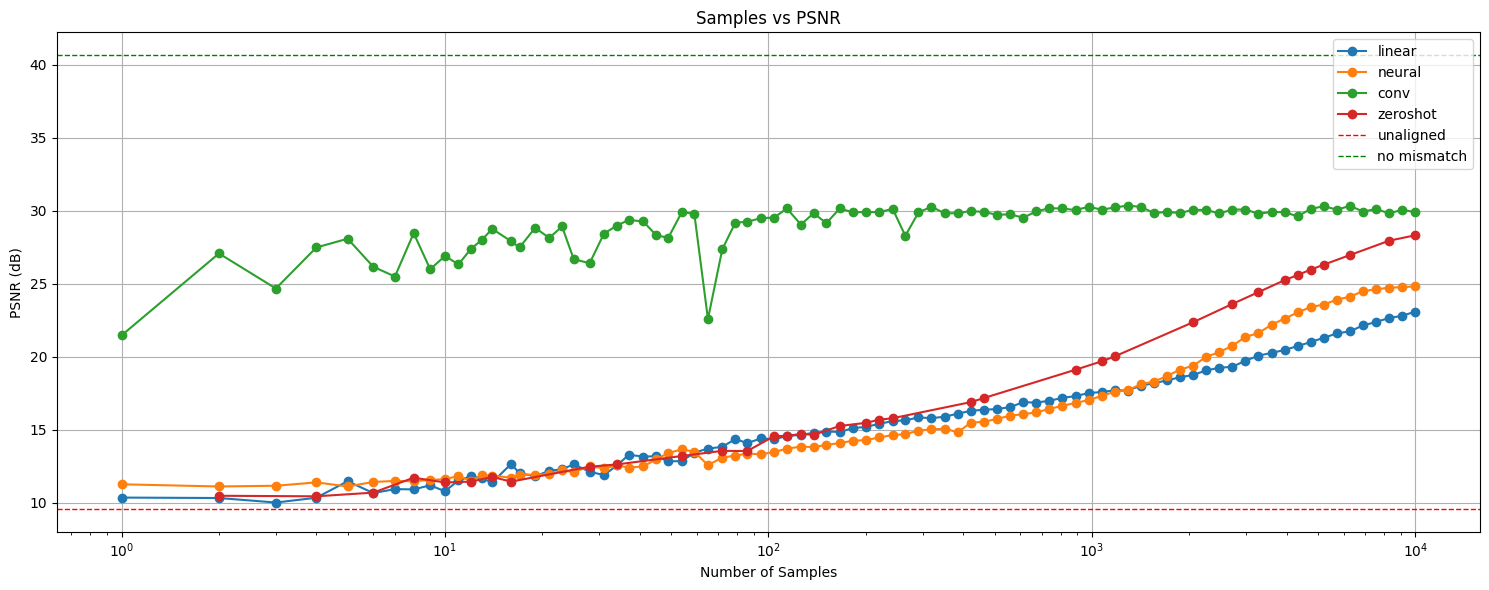

In [ ]:
"""
First group
"""

import matplotlib.pyplot as plt
import re

data = [("linear", text_linear_v1), ("neural", text_neural_v1), ("conv", text_conv_v1), ("zeroshot", text_zeroshot_v1)]

plt.figure(figsize=(15, 6))

# Iterate over all model blocks
for name, text in data:
    matches = re.findall(r'(\d+) samples got a PSNR of ([\d.]+)', text)
    samples = [int(m[0]) for m in matches]
    psnr = [float(m[1]) for m in matches]
    plt.plot(samples, psnr, marker='o', label=name)

plt.axhline(y=9.54, color='red', linestyle='--', linewidth=1, label='unaligned')
plt.axhline(y=40.66, color='green', linestyle='--', linewidth=1, label='no mismatch')

plt.title("Samples vs PSNR")
plt.xlabel("Number of Samples")
plt.ylabel("PSNR (dB)")
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## V2

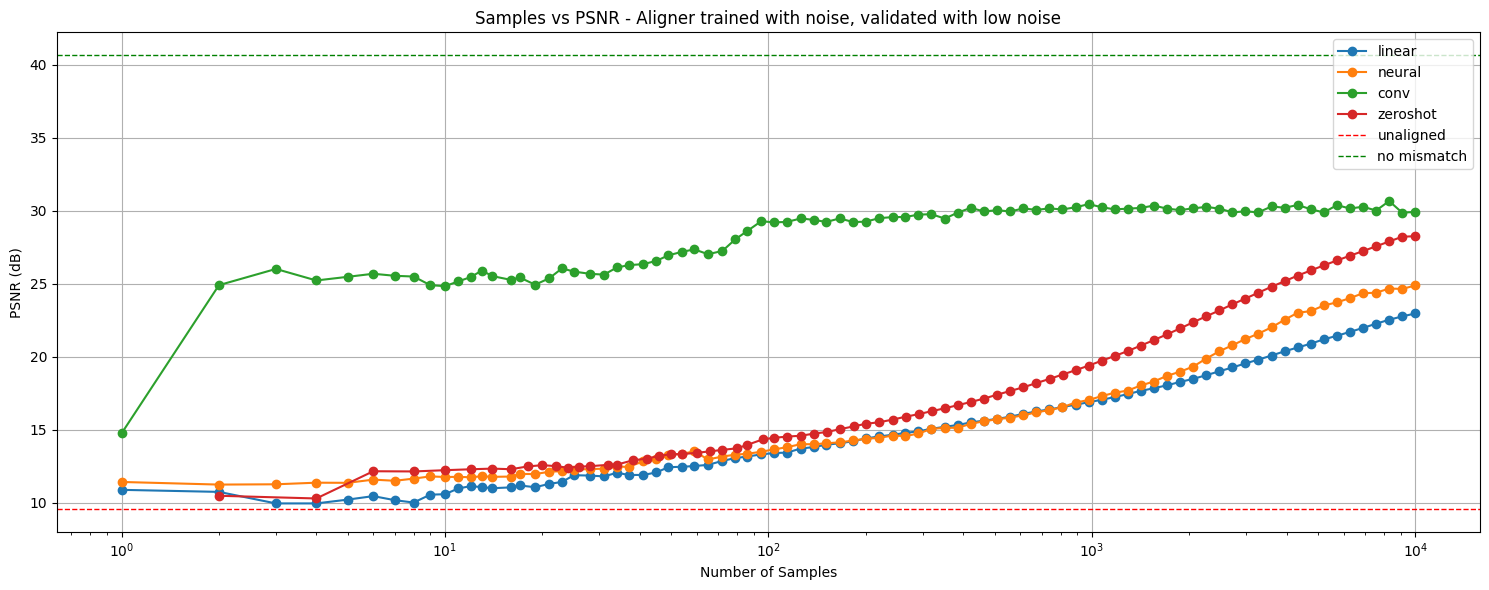

In [38]:
"""
Second group:
- Dataset incrementale
- 1 seed
- Fixato validation zeroshot lento
- 96x96
- Zeroshot con sample size pari
"""

import matplotlib.pyplot as plt
import re

data = [("linear", text_linear_v2), ("neural", text_neural_v2), ("conv", text_conv_v2), ("zeroshot", text_zeroshot_v2)]

plt.figure(figsize=(15, 6))

# Iterate over all model blocks
for name, text in data:
    matches = re.findall(r'(\d+) samples got a PSNR of ([\d.]+)', text)
    samples = [int(m[0]) for m in matches]
    psnr = [float(m[1]) for m in matches]
    plt.plot(samples, psnr, marker='o', label=name)

plt.axhline(y=9.54, color='red', linestyle='--', linewidth=1, label='unaligned')
plt.axhline(y=40.66, color='green', linestyle='--', linewidth=1, label='no mismatch')

plt.title("Samples vs PSNR - Aligner trained with noise, validated with low noise")
plt.xlabel("Number of Samples")
plt.ylabel("PSNR (dB)")
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## V3

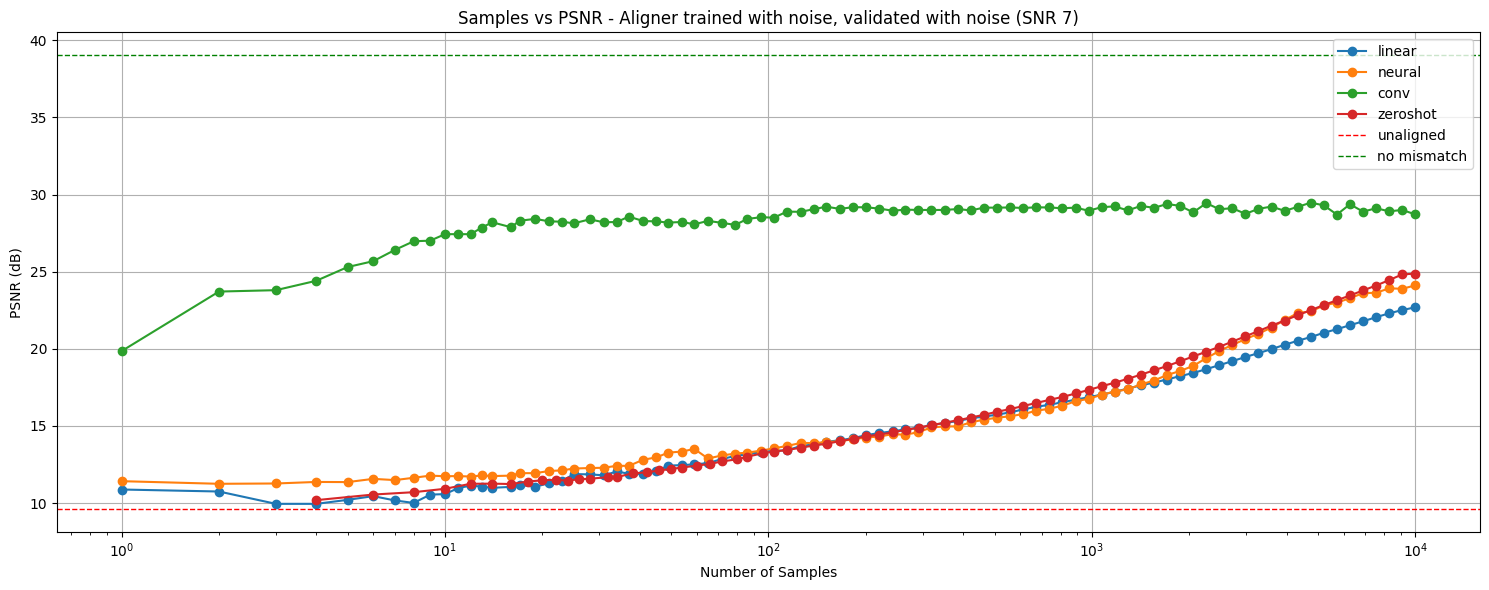

In [34]:
"""
Third group. Same as 2 but validated on SNR 7
"""

import matplotlib.pyplot as plt
import re

data = [("linear", text_linear_v3), ("neural", text_neural_v3), ("conv", text_conv_v3), ("zeroshot", text_zeroshot_v3)]

plt.figure(figsize=(15, 6))

# Iterate over all model blocks
for name, text in data:
    matches = re.findall(r'(\d+) samples got a PSNR of ([\d.]+)', text)
    samples = [int(m[0]) for m in matches]
    psnr = [float(m[1]) for m in matches]
    plt.plot(samples, psnr, marker='o', label=name)

plt.axhline(y=9.59, color='red', linestyle='--', linewidth=1, label='unaligned')
plt.axhline(y=39.04, color='green', linestyle='--', linewidth=1, label='no mismatch')

plt.title("Samples vs PSNR - Aligner trained with noise, validated with noise (SNR 7)")
plt.xlabel("Number of Samples")
plt.ylabel("PSNR (dB)")
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## V4

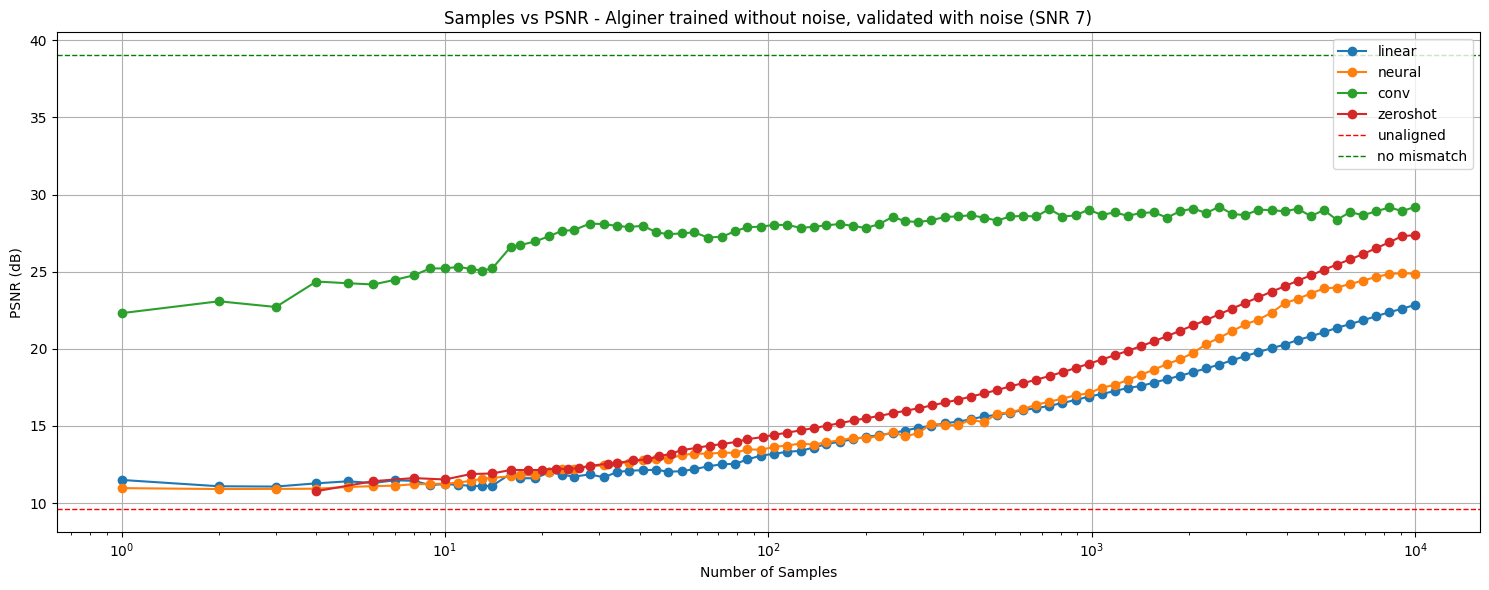

In [9]:
"""
Fourth group. Trained on no noise, validated on SNR 7
"""

import matplotlib.pyplot as plt
import re

data = [("linear", text_linear_v4), ("neural", text_neural_v4), ("conv", text_conv_v4), ("zeroshot", text_zeroshot_v4)]

plt.figure(figsize=(15, 6))

# Iterate over all model blocks
for name, text in data:
    matches = re.findall(r'(\d+) samples got a PSNR of ([\d.]+)', text)
    samples = [int(m[0]) for m in matches]
    psnr = [float(m[1]) for m in matches]
    plt.plot(samples, psnr, marker='o', label=name)

plt.axhline(y=9.59, color='red', linestyle='--', linewidth=1, label='unaligned')
plt.axhline(y=39.04, color='green', linestyle='--', linewidth=1, label='no mismatch')

plt.title("Samples vs PSNR - Alginer trained without noise, validated with noise (SNR 7)")
plt.xlabel("Number of Samples")
plt.ylabel("PSNR (dB)")
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## SNR 0

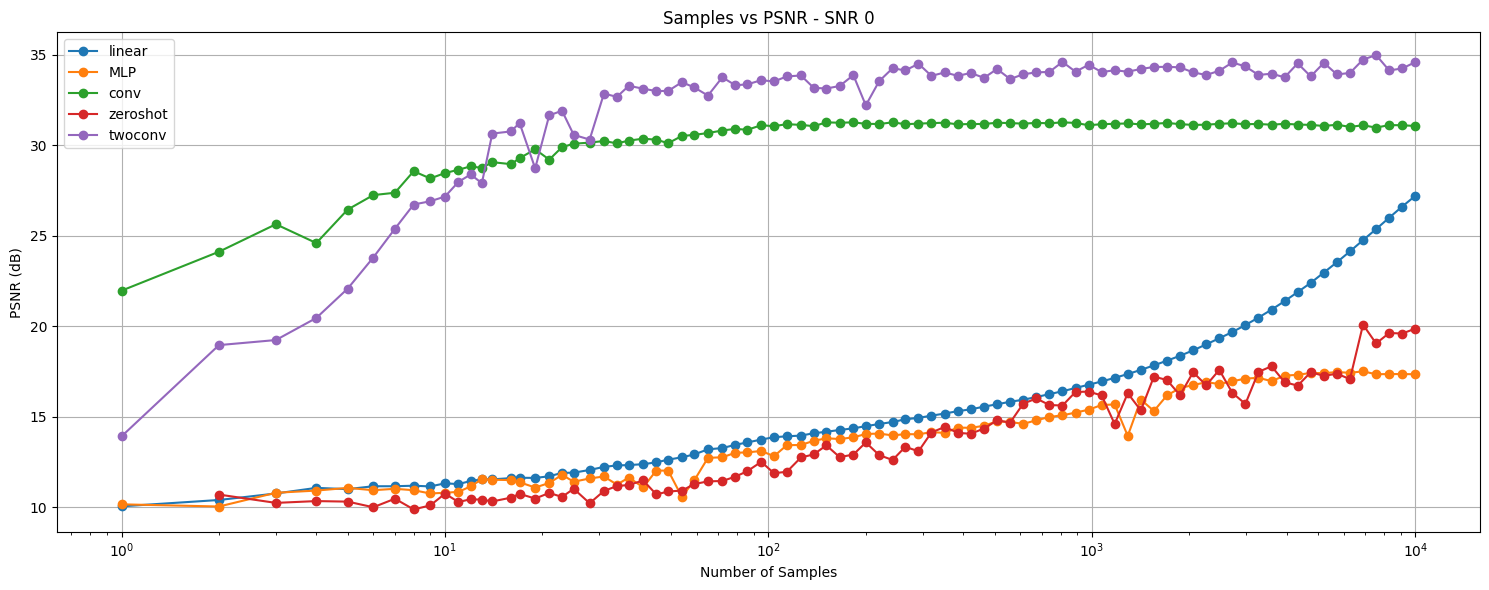

In [12]:
import matplotlib.pyplot as plt
import re

# ("neural", text_neural_snr_0)
data = [("linear", text_linear_snr_0), ("MLP", text_mlp_snr_0), ("conv", text_conv_snr_0), ("zeroshot", text_zeroshot_snr_0), ("twoconv", text_twoconv_snr_0)]

plt.figure(figsize=(15, 6))

# Iterate over all model blocks
for name, text in data:
    matches = re.findall(r'(\d+) samples got a PSNR of ([\d.]+)', text)
    samples = [int(m[0]) for m in matches]
    psnr = [float(m[1]) for m in matches]
    plt.plot(samples, psnr, marker='o', label=name)

# plt.axhline(y=10.80, color='red', linestyle='--', linewidth=1, label='unaligned')
# plt.axhline(y=37.70, color='green', linestyle='--', linewidth=1, label='no mismatch')

plt.title("Samples vs PSNR - SNR 0")
plt.xlabel("Number of Samples")
plt.ylabel("PSNR (dB)")
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## SNR 30

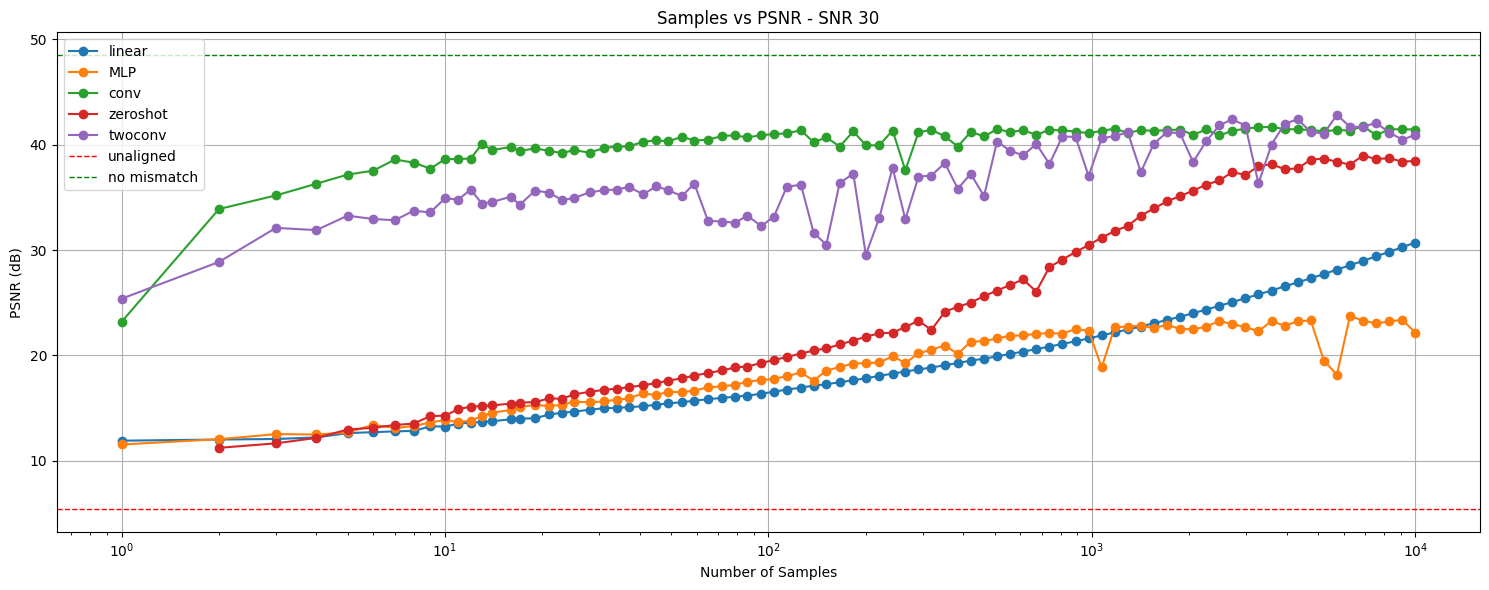

In [6]:
import matplotlib.pyplot as plt
import re

data = [("linear", text_linear_snr_30), ("MLP", text_mlp_snr_30), ("conv", text_conv_snr_30), ("zeroshot", text_zeroshot_snr_30), ("twoconv", text_twoconv_snr_30)]

plt.figure(figsize=(15, 6))

# Iterate over all model blocks
for name, text in data:
    matches = re.findall(r'(\d+) samples got a PSNR of ([\d.]+)', text)
    samples = [int(m[0]) for m in matches]
    psnr = [float(m[1]) for m in matches]
    plt.plot(samples, psnr, marker='o', label=name)

plt.axhline(y=5.39, color='red', linestyle='--', linewidth=1, label='unaligned')
plt.axhline(y=48.50, color='green', linestyle='--', linewidth=1, label='no mismatch')

plt.title("Samples vs PSNR - SNR 30")
plt.xlabel("Number of Samples")
plt.ylabel("PSNR (dB)")
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
"""MLP model, 1 samples got a PSNR of 12.48
MLP model, 2 samples got a PSNR of 12.34
MLP model, 3 samples got a PSNR of 12.31
MLP model, 4 samples got a PSNR of 12.62
MLP model, 5 samples got a PSNR of 13.16
MLP model, 6 samples got a PSNR of 13.22
MLP model, 7 samples got a PSNR of 13.35
MLP model, 8 samples got a PSNR of 13.35
MLP model, 9 samples got a PSNR of 13.48
MLP model, 10 samples got a PSNR of 13.58
MLP model, 11 samples got a PSNR of 13.63
MLP model, 12 samples got a PSNR of 13.64
MLP model, 13 samples got a PSNR of 13.80
MLP model, 14 samples got a PSNR of 13.88
MLP model, 16 samples got a PSNR of 13.89
MLP model, 17 samples got a PSNR of 13.91
MLP model, 19 samples got a PSNR of 13.97
MLP model, 21 samples got a PSNR of 14.09
MLP model, 23 samples got a PSNR of 14.16
MLP model, 25 samples got a PSNR of 14.39
MLP model, 28 samples got a PSNR of 14.56
MLP model, 31 samples got a PSNR of 14.64
MLP model, 34 samples got a PSNR of 14.81
MLP model, 37 samples got a PSNR of 14.91
MLP model, 41 samples got a PSNR of 14.97
MLP model, 45 samples got a PSNR of 15.20
MLP model, 49 samples got a PSNR of 15.26
MLP model, 54 samples got a PSNR of 15.51
MLP model, 59 samples got a PSNR of 15.49
MLP model, 65 samples got a PSNR of 15.47
MLP model, 72 samples got a PSNR of 15.73
MLP model, 79 samples got a PSNR of 15.89
MLP model, 86 samples got a PSNR of 16.09
MLP model, 95 samples got a PSNR of 16.22
MLP model, 104 samples got a PSNR of 16.45
MLP model, 114 samples got a PSNR of 16.68
MLP model, 126 samples got a PSNR of 16.93
MLP model, 138 samples got a PSNR of 16.71
MLP model, 151 samples got a PSNR of 16.91
MLP model, 166 samples got a PSNR of 17.20
MLP model, 183 samples got a PSNR of 17.88
MLP model, 200 samples got a PSNR of 17.65
MLP model, 220 samples got a PSNR of 18.06
MLP model, 242 samples got a PSNR of 18.65
MLP model, 265 samples got a PSNR of 18.54
MLP model, 291 samples got a PSNR of 18.92
MLP model, 319 samples got a PSNR of 19.45
MLP model, 351 samples got a PSNR of 19.68
MLP model, 385 samples got a PSNR of 19.65
MLP model, 422 samples got a PSNR of 20.13
MLP model, 464 samples got a PSNR of 20.32
MLP model, 509 samples got a PSNR of 20.63
MLP model, 559 samples got a PSNR of 20.81
MLP model, 613 samples got a PSNR of 20.99
MLP model, 673 samples got a PSNR of 21.17
MLP model, 739 samples got a PSNR of 21.39
MLP model, 811 samples got a PSNR of 21.48
MLP model, 890 samples got a PSNR of 21.68
MLP model, 977 samples got a PSNR of 21.63
MLP model, 1072 samples got a PSNR of 21.81
MLP model, 1176 samples got a PSNR of 21.91
MLP model, 1291 samples got a PSNR of 22.01
MLP model, 1417 samples got a PSNR of 22.14
MLP model, 1555 samples got a PSNR of 22.23
MLP model, 1707 samples got a PSNR of 22.25
MLP model, 1873 samples got a PSNR of 22.32
MLP model, 2056 samples got a PSNR of 22.31
MLP model, 2257 samples got a PSNR of 22.36
MLP model, 2477 samples got a PSNR of 22.40
MLP model, 2718 samples got a PSNR of 22.47
MLP model, 2983 samples got a PSNR of 22.58
MLP model, 3274 samples got a PSNR of 22.41
MLP model, 3593 samples got a PSNR of 22.50
MLP model, 3944 samples got a PSNR of 22.63
MLP model, 4328 samples got a PSNR of 22.64
MLP model, 4750 samples got a PSNR of 22.52
MLP model, 5214 samples got a PSNR of 22.62
MLP model, 5722 samples got a PSNR of 22.68
MLP model, 6280 samples got a PSNR of 22.62
MLP model, 6892 samples got a PSNR of 22.72
MLP model, 7564 samples got a PSNR of 22.69
MLP model, 8302 samples got a PSNR of 22.84
MLP model, 9111 samples got a PSNR of 22.87
MLP model, 10000 samples got a PSNR of 22.79
"""